In [1]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split, validation_curve, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import LabelBinarizer

from gensim.models import word2vec
from imblearn.under_sampling import NearMiss 
from imblearn.pipeline import make_pipeline

from catboost import CatBoostClassifier, Pool
import xgboost as xgb

from gensim.models import Word2Vec
import gensim

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.client import device_lib 
from numpy import array
from numpy import asarray
from numpy import zeros
from datetime import datetime

from gensim.models.keyedvectors import KeyedVectors

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
df = pd.read_csv('finaldata.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)

In [3]:
df[df.duplicated(['header','text'],keep=False)].sort_values('header').value_counts('label')

label
health        109
business        4
technology      3
science         2
dtype: int64

In [4]:
df[df.duplicated(['header','text'],keep=False)].sort_values('header')

header        datetime  \
3207  'How my jumbo jet art plan took off during Covid'  19-09-21 13:01   
2269  'How my jumbo jet art plan took off during Covid'  18-09-21 13:01   
2274  'Most vulnerable' to get new Covid drug next week   18-09-21 2:56   
3212  'Most vulnerable' to get new Covid drug next week   19-09-21 2:56   
3197    Amber list scrapped for NI, but testing remains  19-09-21 19:25   
...                                                 ...             ...   
3196    What are Northern Ireland's Covid travel rules?  19-09-21 19:40   
2123         Why phone scams are so difficult to tackle   23-08-21 6:30   
534          Why phone scams are so difficult to tackle   23-08-21 6:13   
2255    Woman, 85, receives first care home booster jab  18-09-21 22:32   
3192    Woman, 85, receives first care home booster jab  19-09-21 22:32   

                                                   text       label  
3207                                                NaN      health  
2269                                                NaN      health  
2274  Antibody therapy Ronapreve, given to Donald Tr...      health  
3212  Antibody therapy Ronapreve, given to Donald Tr...      health  
3197  The NI Executive is set to consider changes to...      health  
...                                                 ...         ...  
3196  With guidance on travel changing regularly, BB...      health  
2123  Phone fraud, both via calls and text messages,...    business  
534   Phone fraud, both via calls and text messages,...  technology  
2255  Anne Webb is believed to be the first care hom...      health  
3192  Anne Webb is believed to be the first care hom...      health  

[118 rows x 4 columns]

In [5]:
def convert_label(x):
    if (x == 'technology') | (x=='science'):
        return 'tech&science'
    else :
        return x

In [6]:
bu = ['business','technology','science']

index_dup=df[(df['label'].isin(bu))&df.duplicated(['header','text'],keep=False)].index
df.drop(index=index_dup, inplace=True)

In [7]:
df[df.duplicated(['header','text'],keep=False)].sort_values('header')

header        datetime  \
3207  'How my jumbo jet art plan took off during Covid'  19-09-21 13:01   
2269  'How my jumbo jet art plan took off during Covid'  18-09-21 13:01   
3212  'Most vulnerable' to get new Covid drug next week   19-09-21 2:56   
2274  'Most vulnerable' to get new Covid drug next week   18-09-21 2:56   
2259    Amber list scrapped for NI, but testing remains  18-09-21 19:25   
...                                                 ...             ...   
3219  Want some autumn sun? Your travel guide to the...   19-09-21 0:18   
2258    What are Northern Ireland's Covid travel rules?  18-09-21 19:40   
3196    What are Northern Ireland's Covid travel rules?  19-09-21 19:40   
3192    Woman, 85, receives first care home booster jab  19-09-21 22:32   
2255    Woman, 85, receives first care home booster jab  18-09-21 22:32   

                                                   text   label  
3207                                                NaN  health  
2269                                                NaN  health  
3212  Antibody therapy Ronapreve, given to Donald Tr...  health  
2274  Antibody therapy Ronapreve, given to Donald Tr...  health  
2259  The NI Executive is set to consider changes to...  health  
...                                                 ...     ...  
3219  What you need to know about going to Portugal,...  health  
2258  With guidance on travel changing regularly, BB...  health  
3196  With guidance on travel changing regularly, BB...  health  
3192  Anne Webb is believed to be the first care hom...  health  
2255  Anne Webb is believed to be the first care hom...  health  

[109 rows x 4 columns]

In [8]:
df.drop_duplicates(['header','text'],keep='first',inplace=True)
df[df.duplicated(['header','text'],keep=False)].sort_values('header')

Empty DataFrame
Columns: [header, datetime, text, label]
Index: []

In [9]:
df.value_counts('label')/df.shape[0]*100

label
health        28.067387
science       26.732359
business      25.270184
technology    19.930070
dtype: float64

In [10]:
stopwords = set(stopwords.words('English'))
stopwords=stopwords.union(['will','say','said','says','first','make','see','one','two','year','last','new','part','found','s','m'])
lemma = nltk.WordNetLemmatizer()
snow_stemmer = SnowballStemmer(language='english')

def prep_text(text):
    words=[]
    text = str(text)
    text = re.sub("US","USA",text)
    text = re.sub("\d*\.\d+", " ", text)
    text = re.sub("[^a-zA-Z]"," ",text)
    text = text.lower()
    text = nltk.word_tokenize(text)
    for word in text :
        if word not in stopwords :
            if word != 'media':
                # word = snow_stemmer.stem(word)
                word = lemma.lemmatize(word)
                words.append(word)
            else:
                words.append(word)
    return " ".join(words)

In [11]:
df['text'][df['text'].isnull()] = ''
df['full_text'] = df['header']+' '+ df['text']
df['full_text_prep'] = df['full_text'].apply(prep_text)
#df['label'] = df['label'].apply(convert_label)

In [12]:
tech = [
        'app','microsoft','digital','hacker','youtube','ransomware','streaming',
        'platform','internet','broadband','gaming','whatsapp','instagram','facebook',
        'google','tiktok','twitter','crypto','bitcoin','big tech','online','music','robot',
        'abuse','cyber attack','social media','data','tech','video','hack','tech firm','technology',
        'network','feature','tweet','banned','elon musk','tech','tesla','drone'
        ]

business = [
            "post office", "house price", "electric car", "create job", "price rise", 
            "office scandal", "price", "office", "firm", "pay", "owner", "business", "bank", "job", "sale",
            "lorry driver", "investment bank", "high street", "return office",'ride hailing','competition watchdog',
            "market", "customer", "store",'shop','share', "property", "economy", "supply", "trade", "tax", "buy",
            "pay", "deal", "chain", "food", "demand", "house", "investment", "supermarket"
            ]

sc = [
      'plastic','animal','climate change','area','space','water','storm','tree','beach','cop','wildfire','pollution',
      'scientist','animal','wildlife','carbon','temperature','warming','sea','rain','area','green',
      'fire','wildlife','oil','farm','waste','bird','heat','wind','park','power','rare','plant',
      'net zero','heavy rainfall','low carbon','emission','heatwave',
      'forest','rainfall','solar farm'
      ]

health = [
          "care", "linked", "update", "case", "death case", "vaccine",
          "covid case", "coronavirus", "jab", "rule", "coronavirus morning update", "school", "travel", "coronavirus evening update",
          "booster jab", "total number death linked", "five thing need know", "health", "public health", "pandemic", "death"
          ]

In [13]:
# tech = ["online", "tiktok", "cyber attack", "twitter", "big tech", "social media"]
# sc = ["climate", "flood", "climate change", "storm", "rare", "pollution", "flooding", "heavy rain", "carbon", "warming", "temperature", "wildlife", "animal"]
# business = ["house price", "post office", "create job", "office scandal", "price rise", "price", "ride hailing", "competition watchdog", "investment bank", "high street"]
# health = ["vaccine", "case", "jab", "coronavirus", "death case", "covid case", "morning update", "coronavirus morning update", "coronavirus evening update", "coronavirus evening", "evening update", "booster jab"]

In [14]:
# business = [
#                 "post office", "house price", "create job", "price rise", 
#                 "office scandal", "price",
#                 "bank","investment bank", 
#                 "return office", "ride hailing",  "market", 
#                 "customer", "shop",
#                 "property", "economy",
#                 "chain", "supermarket",
#         ]

# health = [
#                 "care", "linked", "update", "case", "death case", 
#                 "covid", "vaccine", "death",
#                 "covid case", "coronavirus", 
#                 "jab", "coronavirus morning update", "school", 
#                 "coronavirus evening update",
#                 "booster jab", "total number death linked", "five thing need know",
#                 "covid", "health", "public health", "death",
#                 "hospital", "morning", "care", "evening", "pupil", "patient", "booster",
#                 "festival", "total", "vaccinated", "passport"
#         ]

# tech = [
#                 'digital','youtube','ransomware','streaming',
#                 'platform','internet','whatsapp','instagram','facebook',
#                 'tiktok','twitter','crypto','bitcoin','big tech',
#                 'abuse','cyber attack','social media','hack','tech firm',
#                 'feature'
#         ]

# sc = [
#         'plastic','animal','climate change','water','storm','beach','wildfire','pollution',
#         'scientist','animal','wildlife','carbon','temperature','warming',
#         'fire','wildlife','farm','waste','bird','rare',
#         'net zero','low carbon','scientist','emission','heatwave',
#         'forest','marine','rainfall','solar farm'
#       ]

In [15]:
# X = df['full_text_prep']
# y = df['label']

# df.reset_index(inplace=True)
# count_vec = CountVectorizer(ngram_range=(1,4))

# count_vec.fit(X)
# X_ct = count_vec.transform(X)

# df_m = pd.DataFrame(X_ct.toarray(),columns=count_vec.get_feature_names())
# f_tech = df_m[tech]
# f_sc = df_m[sc]
# f_health = df_m[health]
# f_bu = df_m[business]

# df['feature_tech']=f_tech.sum(axis=1)
# df['feature_sc']=f_sc.sum(axis=1)
# df['feature_bu']=f_bu.sum(axis=1)
# df['feature_health']=f_health.sum(axis=1)
# df.to_excel('qqqq.xlsx')

In [35]:
train, test = train_test_split(df, test_size=0.2, random_state=21)
#train, valid = train_test_split(train,test_size=0.2,random_state=21)

print('Train label',train.value_counts('label'))
print('Test label',test.value_counts('label'))

Train label label
health        719
science       670
business      623
technology    504
dtype: int64
Test label label
business      172
science       171
health        164
technology    123
dtype: int64


<AxesSubplot:xlabel='label'>

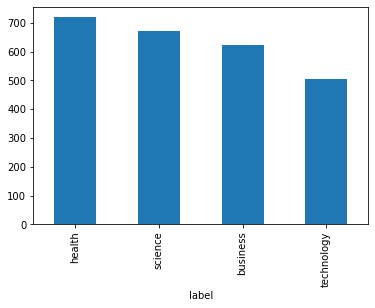

In [17]:
train.value_counts('label').plot.bar()

<AxesSubplot:xlabel='label'>

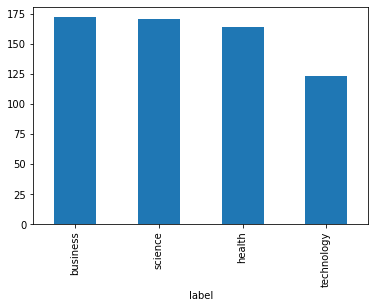

In [18]:
test.value_counts('label').plot.bar()

# Add Feature with TF-IDF

In [19]:
count_vec = CountVectorizer(ngram_range=(1,4))

count_vec.fit(train.full_text_prep)
train_ct = count_vec.transform(train.full_text_prep)

df_ct = pd.DataFrame(train_ct.toarray(),columns=count_vec.get_feature_names())

f_tech = df_ct[tech]
f_sc = df_ct[sc]
f_health = df_ct[health]
f_bu = df_ct[business]

list_f = [f_tech,f_sc,f_health,f_bu]
for f in list_f:
    for i in f.columns:
        f[i]=np.where(f[i]>0,1,f[i])

# f_tech['feature_tech']=f_tech.sum(axis=1)
# f_sc['feature_sc']=f_sc.sum(axis=1)
# f_bu['feature_bu'] = f_bu.sum(axis=1)
# f_health['feature_health']=f_health.sum(axis=1)

df_e = pd.DataFrame()
df_e['feature_tech']=f_tech.sum(axis=1)
df_e['feature_sc']=f_sc.sum(axis=1)
df_e['feature_bu'] = f_bu.sum(axis=1)
df_e['feature_health']=f_health.sum(axis=1)

df_e = normalize(df_e, norm="l1", axis=1)
df_w = pd.DataFrame(df_e,columns=['feature_tech',
                                    'feature_sc',
                                    'feature_bu',
                                    'feature_health'
                                    ])

tfidfvec = TfidfVectorizer(ngram_range=(1,4))
tf=tfidfvec.fit_transform(train.full_text_prep).toarray()
df_idf = pd.DataFrame(tf)
df_idf.columns = tfidfvec.get_feature_names()
df_idf.reset_index(inplace=True)

train_f = pd.concat([df_idf,df_w],axis=1)
train_f.drop(columns='index',inplace=True)
# train_f = pd.merge(df_idf,f_health['feature_health'],left_index=True, right_index=True)
# train_f = pd.merge(train_f,f_bu['feature_bu'],left_index=True, right_index=True)
# train_f = pd.merge(train_f,f_sc['feature_sc'],left_index=True, right_index=True)
# train_f = pd.merge(train_f,f_tech['feature_tech'],left_index=True, right_index=True)

# def cut_x(x):
#     if x > 0 :
#         return 1
#     else :
#         return 0

# list_f = ['feature_health','feature_bu','feature_sc','feature_tech']
# for i in list_f:
#     train_f[i]=train_f[i].apply(cut_x)

<ipython-input-19-aa194821631e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f[i]=np.where(f[i]>0,1,f[i])
<ipython-input-19-aa194821631e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f[i]=np.where(f[i]>0,1,f[i])
<ipython-input-19-aa194821631e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [20]:
X_train_f, X_valid_f ,y_train_f, y_valid_f = train_test_split(train_f, train.label, test_size=0.2, random_state=15)

# For Train, Validation 1 Set

In [21]:
X_train, X_valid ,y_train, y_valid = train_test_split(train.full_text_prep, train.label, test_size=0.2, random_state=15)

([<matplotlib.axis.XTick at 0x28d39858fd0>,
 [Text(0, 0, 'science'),
  Text(1, 0, 'health'),
  Text(2, 0, 'business'),
  Text(3, 0, 'technology')])

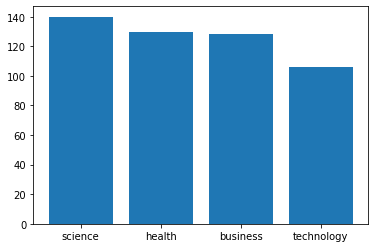

In [22]:
D=Counter(y_valid)
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))

# Tree-Base Model + TF-IDF

In [23]:
dt = DecisionTreeClassifier(random_state=21)
tf_idf = TfidfVectorizer(ngram_range=(1,4))
pipeline = make_pipeline(tf_idf,dt)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)

In [24]:
#print(confusion_matrix(y_valid, y_pred, labels=['business','health','science','technology']))
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

    business       0.54      0.53      0.54       128
      health       0.61      0.75      0.67       130
     science       0.66      0.59      0.63       140
  technology       0.62      0.54      0.58       106

    accuracy                           0.61       504
   macro avg       0.61      0.60      0.60       504
weighted avg       0.61      0.61      0.60       504



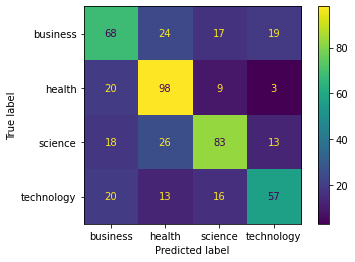

<Figure size 720x720 with 0 Axes>

In [25]:
plot_confusion_matrix(pipeline, X_valid, y_valid)
plt.figure(figsize=(10,10))
plt.show()

<AxesSubplot:>

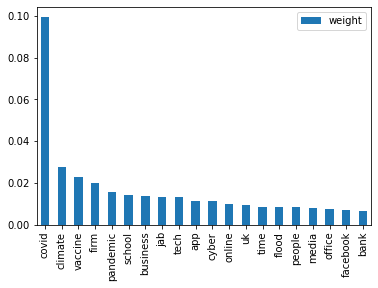

In [26]:
pd.DataFrame(dt.feature_importances_,tf_idf.get_feature_names(), columns=['weight']).sort_values('weight', ascending=False).head(20).plot.bar()

In [93]:
X_train_1, X_valid_1 ,y_train_1, y_valid_1 = train_test_split(train, train.label, test_size=0.2, random_state=15)
X_valid_reset=X_valid_1.reset_index()

df_eva_cattf=pd.DataFrame(y_valid_1.to_list(),columns=['y_true'])
df_eva_cattf['y_pred'] = y_pred

df_eva_cattf['test'] = df_eva_cattf.apply(lambda x: x['y_true'] == x['y_pred'], axis=1)

index_false = df_eva_cattf[df_eva_cattf['test']==False].index.tolist()
X_valid_reset['y_pred'] = y_pred
X_valid_reset.filter(items=index_false, axis=0)[['header','full_text','full_text_prep','label','y_pred']].to_excel('false_dt_tfidf.xlsx')

## Evaluate Model

In [27]:
scores = cross_val_score(pipeline, train.full_text_prep, train.label, cv=10)

In [28]:
np.mean(scores)

0.6530165054069437

(1.0, 100.0)

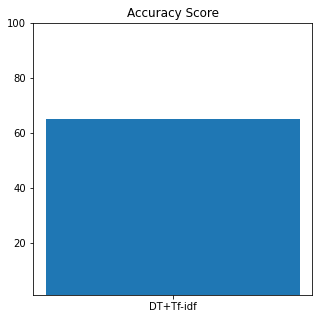

In [29]:
data = {'DT+Tf-idf':65}
plt.figure(figsize=(5,5))
plt.title('Accuracy Score')
plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.ylim(1,100)

# Tree model + TF-IDF + Feature

In [27]:
dt.fit(X_train_f, y_train_f)
y_pred = dt.predict(X_valid_f)

In [28]:
#print(confusion_matrix(y_valid, y_pred, labels=['business','health','science','technology']))
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

    business       0.62      0.55      0.58       128
      health       0.74      0.74      0.74       130
     science       0.68      0.82      0.74       140
  technology       0.71      0.62      0.66       106

    accuracy                           0.69       504
   macro avg       0.69      0.68      0.68       504
weighted avg       0.69      0.69      0.69       504



<AxesSubplot:>

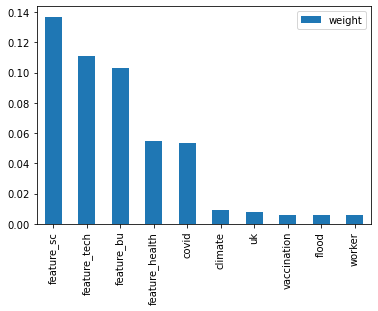

In [29]:
pd.DataFrame(dt.feature_importances_,X_train_f.columns, columns=['weight']).sort_values('weight', ascending=False).head(10).plot.bar()

In [30]:
X_train_1, X_valid_1 ,y_train_1, y_valid_1 = train_test_split(train, train.label, test_size=0.2, random_state=15)
X_valid_reset=X_valid_1.reset_index()

df_eva_cattf=pd.DataFrame(y_valid_1.to_list(),columns=['y_true'])
df_eva_cattf['y_pred'] = y_pred

df_eva_cattf['test'] = df_eva_cattf.apply(lambda x: x['y_true'] == x['y_pred'], axis=1)

index_false = df_eva_cattf[df_eva_cattf['test']==False].index.tolist()
X_valid_reset['y_pred'] = y_pred
X_valid_reset.filter(items=index_false, axis=0)[['full_text','full_text_prep','label','y_pred']].to_excel('false_dt_tfidf_feature.xlsx')

<Figure size 720x720 with 0 Axes>

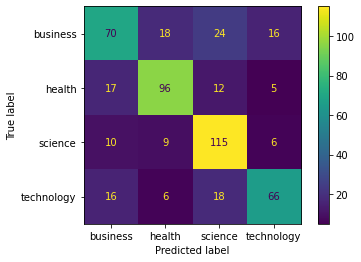

In [31]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(dt, X_valid_f, y_valid_f)
plt.show()

In [32]:
scores = cross_val_score(dt, train_f, train.label, cv=10)
print(np.mean(scores))

0.7042828685258964


([<matplotlib.axis.XTick at 0x1974facdbb0>,
 [Text(0, 0, 'DT+Tf-idf'), Text(1, 0, 'DT+TF-IDF+Feature Extraction')])

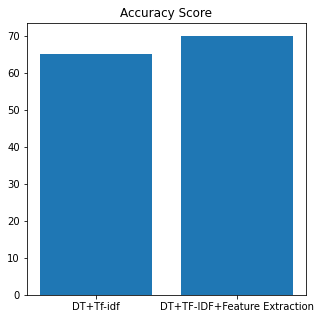

In [33]:
data = {'DT+Tf-idf':65 , 'DT+TF-IDF+Feature Extraction':70}
plt.figure(figsize=(5,5))
plt.title('Accuracy Score')
plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))

# RandomForest + TF-IDF

In [31]:
rf = RandomForestClassifier(random_state=12)
pipeline = make_pipeline(tf_idf,rf)
pipeline.fit(X_train, y_train)
y_pred_rf = pipeline.predict(X_valid)

In [366]:
print(confusion_matrix(y_valid, y_pred_rf, labels=['business','health','science','technology']))
print(classification_report(y_valid, y_pred_rf))

[[ 65  24  21   5]
 [ 20 126   9   0]
 [ 11  20 113   2]
 [ 13  11  11  53]]
              precision    recall  f1-score   support

    business       0.60      0.57      0.58       115
      health       0.70      0.81      0.75       155
     science       0.73      0.77      0.75       146
  technology       0.88      0.60      0.72        88

    accuracy                           0.71       504
   macro avg       0.73      0.69      0.70       504
weighted avg       0.72      0.71      0.71       504



In [367]:
pd.DataFrame(rf.feature_importances_,tf_idf.get_feature_names(), columns=['weight']).sort_values('weight', ascending=False).head(10)

weight
covid           0.022981
vaccine         0.009411
firm            0.007155
climate         0.006545
business        0.006190
case            0.004715
school          0.004413
climate change  0.004196
jab             0.004093
online          0.003825

## Evaluate Model

In [368]:
scores = cross_val_score(pipeline, train.full_text_prep, train.label, cv=10)

In [369]:
np.mean(scores)

0.7326139884904825

## Hyperparameter Tuning

In [49]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [60]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42)

In [61]:
pip = make_pipeline(tf_idf,rf_random)
pip.fit(train.full_text_prep,train.label)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   6.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   6.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   6.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   6.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   6.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  30.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=60

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 4))),
                ('randomizedsearchcv',
                 RandomizedSearchCV(cv=5,
                                    estimator=RandomForestClassifier(n_estimators=300,
                                                                     random_state=12),
                                    param_distributions={'bootstrap': [True,
                                                                       False],
                                                         'max_depth': [10, 20,
                                                                       30, 40,
                                                                       50, 60,
                                                                       70, 80,
                                                                       90, 100,
                                                                       110,
                                           

In [116]:
rf_t=RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_split=10,
                       n_estimators=1000, random_state=12)
pipeline = make_pipeline(tf_idf,rf_t)
pipeline.fit(X_train, y_train)
y_pred_rf = pipeline.predict(X_valid)

In [117]:
print(confusion_matrix(y_valid, y_pred_rf, labels=['business','health','science','technology']))
print(classification_report(y_valid, y_pred_rf))

[[ 87  16  14   9]
 [ 12 110  10   0]
 [  9  14 115   2]
 [ 20  12  15  59]]
              precision    recall  f1-score   support

    business       0.68      0.69      0.69       126
      health       0.72      0.83      0.77       132
     science       0.75      0.82      0.78       140
  technology       0.84      0.56      0.67       106

    accuracy                           0.74       504
   macro avg       0.75      0.73      0.73       504
weighted avg       0.74      0.74      0.73       504



# RandomForest + TF-IDF + Features

In [34]:
rf_t=RandomForestClassifier(
                            bootstrap=False, 
                            max_depth=80, min_samples_split=10,
                            n_estimators=1000, random_state=12
                            )

rf_t.fit(X_train_f, y_train_f)
y_pred = rf_t.predict(X_valid_f)

#print(confusion_matrix(y_valid, y_pred, labels=['business','health','science','technology']))
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

    business       0.76      0.77      0.77       128
      health       0.85      0.82      0.83       130
     science       0.75      0.88      0.81       140
  technology       0.82      0.66      0.73       106

    accuracy                           0.79       504
   macro avg       0.80      0.78      0.79       504
weighted avg       0.79      0.79      0.79       504



<Figure size 720x720 with 0 Axes>

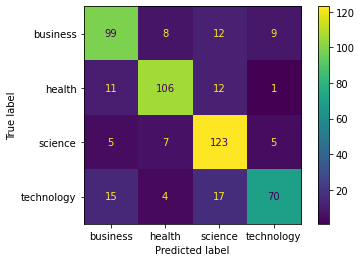

In [36]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(rf_t, X_valid_f, y_valid_f)
plt.show()

<AxesSubplot:>

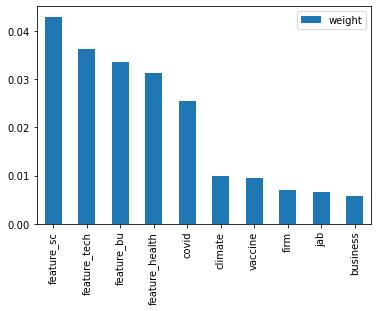

In [37]:
pd.DataFrame(rf_t.feature_importances_,X_train_f.columns, columns=['weight']).sort_values('weight', ascending=False).head(10).plot.bar()

In [40]:
X_train_1, X_valid_1 ,y_train_1, y_valid_1 = train_test_split(train, train.label, test_size=0.2, random_state=15)
X_valid_reset=X_valid_1.reset_index()

df_eva_cattf=pd.DataFrame(y_valid_1.to_list(),columns=['y_true'])
df_eva_cattf['y_pred'] = y_pred

df_eva_cattf['test'] = df_eva_cattf.apply(lambda x: x['y_true'] == x['y_pred'], axis=1)

index_false = df_eva_cattf[df_eva_cattf['test']==False].index.tolist()
X_valid_reset['y_pred'] = y_pred
X_valid_reset.filter(items=index_false, axis=0)[['header','full_text','full_text_prep','label','y_pred']].to_excel('false_rf_tfidf_feature.xlsx')

In [38]:
scores = cross_val_score(rf_t, train_f, train.label, cv=10)
print(np.mean(scores))

0.7794093467400242


In [124]:
print(np.std(scores))

0.019141108732111115


([<matplotlib.axis.XTick at 0x22a46c6d880>,
 [Text(0, 0, 'DT'), Text(1, 0, 'DT+FE'), Text(2, 0, 'RF+FE')])

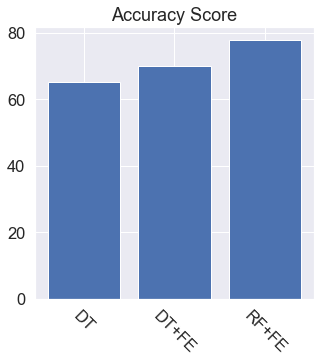

In [76]:
data = {'DT':65.3 , 'DT+FE':70, 'RF+FE':77.9}
plt.figure(figsize=(5,5))
plt.title('Accuracy Score')
plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()),rotation=-45)

# Catboost + TF-IDF

In [31]:
model = CatBoostClassifier(task_type= 'GPU',eval_metric = 'Accuracy',)
pipeline = make_pipeline(tf_idf,model)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
pipeline.score(y_valid, y_pred)

Learning rate set to 0.074856
0:	learn: 0.4488072	total: 206ms	remaining: 3m 25s
1:	learn: 0.5069583	total: 334ms	remaining: 2m 46s
2:	learn: 0.5159046	total: 471ms	remaining: 2m 36s
3:	learn: 0.5447316	total: 585ms	remaining: 2m 25s
4:	learn: 0.5477137	total: 707ms	remaining: 2m 20s
5:	learn: 0.5467197	total: 823ms	remaining: 2m 16s
6:	learn: 0.5566600	total: 934ms	remaining: 2m 12s
7:	learn: 0.5690855	total: 1.04s	remaining: 2m 9s
8:	learn: 0.5675944	total: 1.18s	remaining: 2m 9s
9:	learn: 0.5646123	total: 1.29s	remaining: 2m 7s
10:	learn: 0.5631213	total: 1.39s	remaining: 2m 4s
11:	learn: 0.5670974	total: 1.5s	remaining: 2m 3s
12:	learn: 0.5700795	total: 1.61s	remaining: 2m 2s
13:	learn: 0.5760437	total: 1.74s	remaining: 2m 2s
14:	learn: 0.5760437	total: 1.83s	remaining: 2m
15:	learn: 0.5770378	total: 1.92s	remaining: 1m 58s
16:	learn: 0.5780318	total: 2.04s	remaining: 1m 57s
17:	learn: 0.5785288	total: 2.14s	remaining: 1m 56s
18:	learn: 0.5810139	total: 2.26s	remaining: 1m 56s
19:	

0.25536974048878813

In [80]:
print(confusion_matrix(y_valid, y_pred, labels=['business','health','science','technology']))
print(classification_report(y_valid, y_pred))

[[ 77  20  17  12]
 [  7 134  13   3]
 [  6  10 108   4]
 [ 12   6  14  61]]
              precision    recall  f1-score   support

    business       0.75      0.61      0.68       126
      health       0.79      0.85      0.82       157
     science       0.71      0.84      0.77       128
  technology       0.76      0.66      0.71        93

    accuracy                           0.75       504
   macro avg       0.75      0.74      0.74       504
weighted avg       0.76      0.75      0.75       504



In [81]:
pd.DataFrame(model.feature_importances_,tf_idf.get_feature_names(), columns=['weight']).sort_values('weight', ascending=False).head(20)

weight
covid         15.441261
tech           4.658627
vaccine        3.432704
climate        3.172433
firm           2.493345
online         2.319219
app            2.133796
data           2.093835
business       1.970291
cyber          1.874649
social media   1.555834
google         1.426983
jab            1.335395
hacker         1.281775
social         1.251850
bitcoin        1.239702
pandemic       1.179781
abuse          1.134546
facebook       0.986894
company        0.979261

In [206]:
X_train_1, X_valid_1 ,y_train_1, y_valid_1 = train_test_split(train, train.label, test_size=0.2, random_state=5)
X_valid_reset=X_valid_1.reset_index()

df_eva_cattf=pd.DataFrame(y_valid_1.to_list(),columns=['y_true'])
df_eva_cattf['y_pred'] = y_pred

df_eva_cattf['test'] = df_eva_cattf.apply(lambda x: x['y_true'] == x['y_pred'], axis=1)

index_false = df_eva_cattf[df_eva_cattf['test']==False].index.tolist()
X_valid_reset['y_pred'] = y_pred
X_valid_reset.filter(items=index_false, axis=0)[['full_text','full_text_prep','label','y_pred']].to_excel('false_cat_tfidf.xlsx')

## Evaluate Catboost + tf-idf

In [82]:
model = CatBoostClassifier(task_type= 'GPU')
pipeline = make_pipeline(tf_idf,model)
scores = cross_val_score(pipeline, train.full_text_prep, train.label, cv=10)

Learning rate set to 0.076693
0:	learn: 1.3482350	total: 203ms	remaining: 3m 22s
1:	learn: 1.3217395	total: 325ms	remaining: 2m 42s
2:	learn: 1.2954756	total: 453ms	remaining: 2m 30s
3:	learn: 1.2739891	total: 586ms	remaining: 2m 26s
4:	learn: 1.2565130	total: 711ms	remaining: 2m 21s
5:	learn: 1.2399851	total: 838ms	remaining: 2m 18s
6:	learn: 1.2247586	total: 984ms	remaining: 2m 19s
7:	learn: 1.2113128	total: 1.12s	remaining: 2m 19s
8:	learn: 1.2001313	total: 1.24s	remaining: 2m 16s
9:	learn: 1.1888023	total: 1.35s	remaining: 2m 14s
10:	learn: 1.1788241	total: 1.49s	remaining: 2m 14s
11:	learn: 1.1686561	total: 1.64s	remaining: 2m 14s
12:	learn: 1.1595168	total: 1.76s	remaining: 2m 13s
13:	learn: 1.1514294	total: 1.88s	remaining: 2m 12s
14:	learn: 1.1427867	total: 2.02s	remaining: 2m 12s
15:	learn: 1.1343179	total: 2.14s	remaining: 2m 11s
16:	learn: 1.1274208	total: 2.25s	remaining: 2m 10s
17:	learn: 1.1203229	total: 2.38s	remaining: 2m 9s
18:	learn: 1.1139749	total: 2.47s	remaining: 

In [83]:
np.mean(scores)

0.7533469297413521

In [119]:
# catboost_params = {
#     'iterations': 3000,
#     'learning_rate': 0.01,
#     'eval_metric' : 'Accuracy',
#     'loss_function': 'MultiClass',
#     'task_type': 'CPU',
#     'early_stopping_rounds': 100,
#     'use_best_model': True,
#     'verbose': 1,
#     'depth' : 5,
#     'train_dir': 'crossentropy',
#     }

# Catboost + TF-IDF + Features

In [411]:
model = CatBoostClassifier(task_type= 'GPU',eval_metric = 'Accuracy', use_best_model=True)

model.fit(X_train_f, y_train_f, eval_set=(X_valid_f, y_valid_f))

Learning rate set to 0.112855
0:	learn: 0.7088922	test: 0.7043651	best: 0.7043651 (0)	total: 59.5ms	remaining: 59.5s
1:	learn: 0.7093890	test: 0.7023810	best: 0.7043651 (0)	total: 105ms	remaining: 52.3s
2:	learn: 0.7113761	test: 0.7023810	best: 0.7043651 (0)	total: 156ms	remaining: 51.7s
3:	learn: 0.7118728	test: 0.7043651	best: 0.7043651 (0)	total: 194ms	remaining: 48.4s
4:	learn: 0.7183308	test: 0.7123016	best: 0.7123016 (4)	total: 240ms	remaining: 47.8s
5:	learn: 0.7183308	test: 0.7043651	best: 0.7123016 (4)	total: 285ms	remaining: 47.2s
6:	learn: 0.7143567	test: 0.7063492	best: 0.7123016 (4)	total: 321ms	remaining: 45.6s
7:	learn: 0.7098857	test: 0.7043651	best: 0.7123016 (4)	total: 370ms	remaining: 45.9s
8:	learn: 0.7118728	test: 0.7043651	best: 0.7123016 (4)	total: 414ms	remaining: 45.6s
9:	learn: 0.7108793	test: 0.7043651	best: 0.7123016 (4)	total: 454ms	remaining: 45s
10:	learn: 0.7123696	test: 0.7063492	best: 0.7123016 (4)	total: 498ms	remaining: 44.8s
11:	learn: 0.7143567	tes

In [412]:
y_pred_1 = model.predict(X_valid_f)
print(confusion_matrix(y_valid_f, y_pred_1, labels=['business','health','science','technology']))
print(classification_report(y_valid_f, y_pred_1))

[[ 73   9  27   6]
 [ 25 108  21   1]
 [  9   7 128   2]
 [  9   4  15  60]]
              precision    recall  f1-score   support

    business       0.63      0.63      0.63       115
      health       0.84      0.70      0.76       155
     science       0.67      0.88      0.76       146
  technology       0.87      0.68      0.76        88

    accuracy                           0.73       504
   macro avg       0.75      0.72      0.73       504
weighted avg       0.75      0.73      0.73       504



In [26]:
pd.DataFrame(model.feature_importances_,X_train_f.columns, columns=['weight']).sort_values('weight', ascending=False).head(10)

weight
feature_tech    22.555977
feature_health  16.295961
feature_sc      10.791175
feature_bu       6.432744
7130             3.866682
11715            2.042810
1375             2.002071
7852             2.001070
20709            1.855308
4041             1.418535

In [103]:
X_train_1, X_valid_1 ,y_train_1, y_valid_1 = train_test_split(train, train.label, test_size=0.2, random_state=5)
X_valid_reset=X_valid_1.reset_index()

df_eva_cattf=pd.DataFrame(y_valid_1.to_list(),columns=['y_true'])
df_eva_cattf['y_pred'] = y_pred

df_eva_cattf['test'] = df_eva_cattf.apply(lambda x: x['y_true'] == x['y_pred'], axis=1)

index_false = df_eva_cattf[df_eva_cattf['test']==False].index.tolist()
X_valid_reset['y_pred'] = y_pred
X_valid_reset.filter(items=index_false, axis=0)[['full_text','full_text_prep','label','y_pred']].to_excel('false_cat_tfidf_feature.xlsx')

In [27]:
model = CatBoostClassifier(task_type= 'GPU',eval_metric = 'Accuracy')
scores = cross_val_score(model, train_f, train.label, cv=10)
print(np.mean(scores))

Learning rate set to 0.076686
0:	learn: 0.6432671	total: 64.1ms	remaining: 1m 4s
1:	learn: 0.6494481	total: 106ms	remaining: 53.1s
2:	learn: 0.6485651	total: 147ms	remaining: 48.8s
3:	learn: 0.6467991	total: 193ms	remaining: 48s
4:	learn: 0.6494481	total: 234ms	remaining: 46.7s
5:	learn: 0.6503311	total: 276ms	remaining: 45.7s
6:	learn: 0.6565121	total: 316ms	remaining: 44.8s
7:	learn: 0.6573951	total: 354ms	remaining: 43.8s
8:	learn: 0.6569536	total: 394ms	remaining: 43.4s
9:	learn: 0.6573951	total: 437ms	remaining: 43.3s
10:	learn: 0.6604857	total: 476ms	remaining: 42.8s
11:	learn: 0.6604857	total: 518ms	remaining: 42.7s
12:	learn: 0.6604857	total: 556ms	remaining: 42.2s
13:	learn: 0.6657837	total: 602ms	remaining: 42.4s
14:	learn: 0.6666667	total: 641ms	remaining: 42.1s
15:	learn: 0.6679912	total: 681ms	remaining: 41.9s
16:	learn: 0.6684327	total: 727ms	remaining: 42s
17:	learn: 0.6706402	total: 765ms	remaining: 41.8s
18:	learn: 0.6706402	total: 802ms	remaining: 41.4s
19:	learn: 0.6

# Word2Vec with Catboost

In [23]:
from gensim.models import Word2Vec
import gensim

wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [24]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [25]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [26]:
valid_tokenized = X_valid.apply(lambda r: w2v_tokenize_text(r)).values
train_tokenized = X_train.apply(lambda r: w2v_tokenize_text(r)).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_valid_word_average = word_averaging_list(wv,valid_tokenized)

<ipython-input-24-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


In [68]:
s = 'youtube to remove all anti vaccine misinformation'

e=w2v_tokenize_text(s)

t=word_averaging(wv,e)
pd.DataFrame(t.reshape(1,300))

<ipython-input-65-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


0         1         2         3         4         5         6    \
0 -0.011745  0.031735  0.058349  0.062088 -0.103237 -0.038376 -0.011933   

        7        8         9    ...       290       291       292       293  \
0 -0.016817  0.15807  0.000338  ... -0.006826  0.000861 -0.045661 -0.002333   

        294      295       296       297      298       299  
0 -0.043957 -0.00021  0.023425  0.005768  0.03478  0.023814  

[1 rows x 300 columns]

In [69]:
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'eval_metric' : 'Accuracy',
    'loss_function': 'MultiClass',
    'task_type': 'GPU',
    'early_stopping_rounds': 200,
    'use_best_model': True,
    'depth' : 6,
    'train_dir': 'crossentropy',
    'l2_leaf_reg' : 3
    }

In [27]:
model = CatBoostClassifier(**catboost_params)
model = model.fit(X_train_word_average, y_train,eval_set=(X_valid_word_average,y_valid))
y_pred = model.predict(X_valid_word_average)

0:	learn: 0.5661034	test: 0.5119048	best: 0.5119048 (0)	total: 42.4ms	remaining: 42.3s
1:	learn: 0.6003976	test: 0.5099206	best: 0.5119048 (0)	total: 60.9ms	remaining: 30.4s
2:	learn: 0.6466203	test: 0.5595238	best: 0.5595238 (2)	total: 78.4ms	remaining: 26.1s
3:	learn: 0.6640159	test: 0.6011905	best: 0.6011905 (3)	total: 97.2ms	remaining: 24.2s
4:	learn: 0.6804175	test: 0.6071429	best: 0.6071429 (4)	total: 115ms	remaining: 22.9s
5:	learn: 0.6829026	test: 0.6289683	best: 0.6289683 (5)	total: 135ms	remaining: 22.3s
6:	learn: 0.6933400	test: 0.6130952	best: 0.6289683 (5)	total: 154ms	remaining: 21.8s
7:	learn: 0.7102386	test: 0.6349206	best: 0.6349206 (7)	total: 172ms	remaining: 21.3s
8:	learn: 0.7191849	test: 0.6309524	best: 0.6349206 (7)	total: 188ms	remaining: 20.8s
9:	learn: 0.7286282	test: 0.6349206	best: 0.6349206 (7)	total: 206ms	remaining: 20.4s
10:	learn: 0.7301193	test: 0.6250000	best: 0.6349206 (7)	total: 225ms	remaining: 20.2s
11:	learn: 0.7400596	test: 0.6250000	best: 0.6349

In [29]:
#model = CatBoostClassifier(task_type= 'GPU',eval_metric = 'Accuracy')
# model = model.fit(X_train_word_average, y_train,eval_set=(X_valid_word_average,y_valid))
# y_pred = model.predict(X_valid_word_average)

In [28]:
print('accuracy %s' % accuracy_score(y_valid,y_pred))
print(confusion_matrix(y_valid, y_pred, labels=['business','health','science','technology']))
print(classification_report(y_valid, y_pred))

accuracy 0.7916666666666666
[[ 93  10  10  15]
 [  9 111   7   3]
 [  5  11 120   4]
 [ 12   7  12  75]]
              precision    recall  f1-score   support

    business       0.78      0.73      0.75       128
      health       0.80      0.85      0.83       130
     science       0.81      0.86      0.83       140
  technology       0.77      0.71      0.74       106

    accuracy                           0.79       504
   macro avg       0.79      0.79      0.79       504
weighted avg       0.79      0.79      0.79       504



<Figure size 720x720 with 0 Axes>

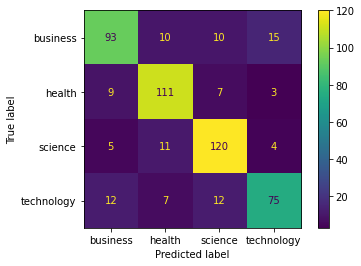

In [31]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(model, X_valid_word_average, y_valid)
plt.show()

In [50]:
X_train_1, X_valid_1 ,y_train_1, y_valid_1 = train_test_split(train, train.label, test_size=0.2, random_state=15)
X_valid_reset=X_valid_1.reset_index()

df_eva_cattf=pd.DataFrame(y_valid_1.to_list(),columns=['y_true'])
df_eva_cattf['y_pred'] = y_pred

df_eva_cattf['test'] = df_eva_cattf.apply(lambda x: x['y_true'] == x['y_pred'], axis=1)

index_false = df_eva_cattf[df_eva_cattf['test']==False].index.tolist()
X_valid_reset['y_pred'] = y_pred
X_valid_reset.filter(items=index_false, axis=0)[['header','full_text','full_text_prep','label','y_pred']].to_excel('false_cat_w2v.xlsx')

## Evaluate Model Catboost + W2V

In [70]:
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'eval_metric' : 'Accuracy',
    'loss_function': 'MultiClass',
    'task_type': 'GPU',
    'early_stopping_rounds': 200,
    'use_best_model': True,
    'depth' : 6,
    'train_dir': 'crossentropy',
    'l2_leaf_reg' : 3
    }

In [51]:
from sklearn.model_selection import KFold
K = 10
kf = KFold(n_splits = K, random_state = 101, shuffle = True)

OPTIMIZE_ROUNDS = False

In [72]:
acc = []
model_catw2v = CatBoostClassifier(**catboost_params)
for i, (train_index, test_index) in enumerate(kf.split(train)):
    
    # Create data for this fold
    y_train_cv, y_valid_cv = train['label'].iloc[train_index], train['label'].iloc[test_index]
    X_train_cv, X_valid_cv = train.iloc[train_index,:], train.iloc[test_index,:]
    print( "\nFold ", i)
    
    test_tokenized_cv = X_valid_cv.apply(lambda r: w2v_tokenize_text(r['full_text_prep']), axis=1).values
    train_tokenized_cv = X_train_cv.apply(lambda r: w2v_tokenize_text(r['full_text_prep']), axis=1).values

    X_train_word_average_cv = word_averaging_list(wv,train_tokenized_cv)
    X_test_word_average_cv = word_averaging_list(wv,test_tokenized_cv)

    fit_model = model_catw2v.fit(X_train_word_average_cv, y_train_cv,
                              eval_set=(X_test_word_average_cv,y_valid_cv))
        
    # Generate validation predictions for this fold
    pred = fit_model.predict(X_test_word_average_cv)
    print( "  Accuracy = ", accuracy_score(y_valid_cv, pred))
    acc.append(accuracy_score(y_valid_cv, pred))
print('Mean Accuracy', np.mean(acc))


Fold  0


<ipython-input-65-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


0:	learn: 0.5755300	test: 0.4761905	best: 0.4761905 (0)	total: 30.2ms	remaining: 30.2s
1:	learn: 0.6223498	test: 0.5317460	best: 0.5317460 (1)	total: 53ms	remaining: 26.4s
2:	learn: 0.6320671	test: 0.5317460	best: 0.5317460 (1)	total: 72.6ms	remaining: 24.1s
3:	learn: 0.6581272	test: 0.5634921	best: 0.5634921 (3)	total: 91.8ms	remaining: 22.9s
4:	learn: 0.6559187	test: 0.5634921	best: 0.5634921 (3)	total: 111ms	remaining: 22.2s
5:	learn: 0.6647527	test: 0.5436508	best: 0.5634921 (3)	total: 130ms	remaining: 21.5s
6:	learn: 0.6810954	test: 0.5555556	best: 0.5634921 (3)	total: 150ms	remaining: 21.3s
7:	learn: 0.6943463	test: 0.5753968	best: 0.5753968 (7)	total: 170ms	remaining: 21s
8:	learn: 0.6996466	test: 0.5912698	best: 0.5912698 (8)	total: 188ms	remaining: 20.6s
9:	learn: 0.7084806	test: 0.6111111	best: 0.6111111 (9)	total: 207ms	remaining: 20.5s
10:	learn: 0.7186396	test: 0.6071429	best: 0.6111111 (9)	total: 226ms	remaining: 20.3s
11:	learn: 0.7296820	test: 0.6269841	best: 0.6269841 

<ipython-input-65-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


0:	learn: 0.5781802	test: 0.5039683	best: 0.5039683 (0)	total: 17.7ms	remaining: 17.6s
1:	learn: 0.6223498	test: 0.5555556	best: 0.5555556 (1)	total: 33.8ms	remaining: 16.9s
2:	learn: 0.6568021	test: 0.6150794	best: 0.6150794 (2)	total: 50.3ms	remaining: 16.7s
3:	learn: 0.6581272	test: 0.5873016	best: 0.6150794 (2)	total: 66.3ms	remaining: 16.5s
4:	learn: 0.6722615	test: 0.6230159	best: 0.6230159 (4)	total: 82.9ms	remaining: 16.5s
5:	learn: 0.6815371	test: 0.6111111	best: 0.6230159 (4)	total: 99.3ms	remaining: 16.4s
6:	learn: 0.6925795	test: 0.6388889	best: 0.6388889 (6)	total: 117ms	remaining: 16.5s
7:	learn: 0.6983216	test: 0.6269841	best: 0.6388889 (6)	total: 133ms	remaining: 16.4s
8:	learn: 0.7067138	test: 0.6150794	best: 0.6388889 (6)	total: 152ms	remaining: 16.8s
9:	learn: 0.7146643	test: 0.6269841	best: 0.6388889 (6)	total: 171ms	remaining: 16.9s
10:	learn: 0.7310071	test: 0.6388889	best: 0.6388889 (6)	total: 189ms	remaining: 17s
11:	learn: 0.7323322	test: 0.6507937	best: 0.6507

<ipython-input-65-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


0:	learn: 0.5755300	test: 0.4801587	best: 0.4801587 (0)	total: 18.6ms	remaining: 18.6s
1:	learn: 0.6090989	test: 0.5238095	best: 0.5238095 (1)	total: 35.9ms	remaining: 17.9s
2:	learn: 0.6280919	test: 0.5396825	best: 0.5396825 (2)	total: 51.6ms	remaining: 17.1s
3:	learn: 0.6333922	test: 0.5555556	best: 0.5555556 (3)	total: 68ms	remaining: 16.9s
4:	learn: 0.6598940	test: 0.5595238	best: 0.5595238 (4)	total: 84.3ms	remaining: 16.8s
5:	learn: 0.6687279	test: 0.5753968	best: 0.5753968 (5)	total: 101ms	remaining: 16.7s
6:	learn: 0.6890459	test: 0.5873016	best: 0.5873016 (6)	total: 118ms	remaining: 16.7s
7:	learn: 0.6925795	test: 0.6031746	best: 0.6031746 (7)	total: 135ms	remaining: 16.7s
8:	learn: 0.7040636	test: 0.6150794	best: 0.6150794 (8)	total: 153ms	remaining: 16.9s
9:	learn: 0.7181979	test: 0.6150794	best: 0.6150794 (8)	total: 171ms	remaining: 17s
10:	learn: 0.7270318	test: 0.6031746	best: 0.6150794 (8)	total: 192ms	remaining: 17.3s
11:	learn: 0.7332155	test: 0.6111111	best: 0.6150794

<ipython-input-65-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


0:	learn: 0.5702297	test: 0.5238095	best: 0.5238095 (0)	total: 17.9ms	remaining: 17.9s
1:	learn: 0.6121908	test: 0.5793651	best: 0.5793651 (1)	total: 33.5ms	remaining: 16.7s
2:	learn: 0.6347173	test: 0.5952381	best: 0.5952381 (2)	total: 49.5ms	remaining: 16.5s
3:	learn: 0.6585689	test: 0.6349206	best: 0.6349206 (3)	total: 65.2ms	remaining: 16.2s
4:	learn: 0.6638693	test: 0.6309524	best: 0.6349206 (3)	total: 81ms	remaining: 16.1s
5:	learn: 0.6674028	test: 0.6507937	best: 0.6507937 (5)	total: 98.8ms	remaining: 16.4s
6:	learn: 0.6841873	test: 0.6468254	best: 0.6507937 (5)	total: 116ms	remaining: 16.5s
7:	learn: 0.6890459	test: 0.6547619	best: 0.6547619 (7)	total: 134ms	remaining: 16.6s
8:	learn: 0.6965548	test: 0.6666667	best: 0.6666667 (8)	total: 151ms	remaining: 16.6s
9:	learn: 0.7093640	test: 0.6587302	best: 0.6666667 (8)	total: 171ms	remaining: 16.9s
10:	learn: 0.7146643	test: 0.6666667	best: 0.6666667 (8)	total: 193ms	remaining: 17.3s
11:	learn: 0.7230565	test: 0.6825397	best: 0.6825

<ipython-input-65-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


0:	learn: 0.5697880	test: 0.5396825	best: 0.5396825 (0)	total: 19.5ms	remaining: 19.5s
1:	learn: 0.6232332	test: 0.5555556	best: 0.5555556 (1)	total: 38.3ms	remaining: 19.1s
2:	learn: 0.6568021	test: 0.5753968	best: 0.5753968 (2)	total: 56.6ms	remaining: 18.8s
3:	learn: 0.6510601	test: 0.5634921	best: 0.5753968 (2)	total: 72.8ms	remaining: 18.1s
4:	learn: 0.6660777	test: 0.5714286	best: 0.5753968 (2)	total: 88.5ms	remaining: 17.6s
5:	learn: 0.6850707	test: 0.6071429	best: 0.6071429 (5)	total: 104ms	remaining: 17.2s
6:	learn: 0.7036219	test: 0.6230159	best: 0.6230159 (6)	total: 120ms	remaining: 17.1s
7:	learn: 0.7089223	test: 0.6071429	best: 0.6230159 (6)	total: 138ms	remaining: 17.1s
8:	learn: 0.7120141	test: 0.6190476	best: 0.6230159 (6)	total: 156ms	remaining: 17.1s
9:	learn: 0.7283569	test: 0.6230159	best: 0.6230159 (6)	total: 177ms	remaining: 17.5s
10:	learn: 0.7349823	test: 0.6309524	best: 0.6309524 (10)	total: 192ms	remaining: 17.3s
11:	learn: 0.7411661	test: 0.6349206	best: 0.63

<ipython-input-65-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


0:	learn: 0.5689046	test: 0.5317460	best: 0.5317460 (0)	total: 17.2ms	remaining: 17.2s
1:	learn: 0.6192580	test: 0.5515873	best: 0.5515873 (1)	total: 32.6ms	remaining: 16.2s
2:	learn: 0.6550353	test: 0.5793651	best: 0.5793651 (2)	total: 47.9ms	remaining: 15.9s
3:	learn: 0.6563604	test: 0.6230159	best: 0.6230159 (3)	total: 63.9ms	remaining: 15.9s
4:	learn: 0.6696113	test: 0.6150794	best: 0.6230159 (3)	total: 81.1ms	remaining: 16.1s
5:	learn: 0.6903710	test: 0.6111111	best: 0.6230159 (3)	total: 101ms	remaining: 16.7s
6:	learn: 0.7009717	test: 0.6031746	best: 0.6230159 (3)	total: 116ms	remaining: 16.5s
7:	learn: 0.7093640	test: 0.6190476	best: 0.6230159 (3)	total: 135ms	remaining: 16.7s
8:	learn: 0.7190813	test: 0.6269841	best: 0.6269841 (8)	total: 151ms	remaining: 16.7s
9:	learn: 0.7248233	test: 0.6309524	best: 0.6309524 (9)	total: 170ms	remaining: 16.8s
10:	learn: 0.7287986	test: 0.6468254	best: 0.6468254 (10)	total: 191ms	remaining: 17.1s
11:	learn: 0.7367491	test: 0.6507937	best: 0.65

<ipython-input-65-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


0:	learn: 0.5814570	test: 0.5258964	best: 0.5258964 (0)	total: 18.8ms	remaining: 18.7s
1:	learn: 0.6017660	test: 0.5776892	best: 0.5776892 (1)	total: 35.5ms	remaining: 17.7s
2:	learn: 0.6437086	test: 0.6135458	best: 0.6135458 (2)	total: 52.6ms	remaining: 17.5s
3:	learn: 0.6534216	test: 0.6254980	best: 0.6254980 (3)	total: 69.4ms	remaining: 17.3s
4:	learn: 0.6662252	test: 0.6254980	best: 0.6254980 (3)	total: 85.1ms	remaining: 16.9s
5:	learn: 0.6812362	test: 0.6215139	best: 0.6254980 (3)	total: 102ms	remaining: 16.9s
6:	learn: 0.6896247	test: 0.6653386	best: 0.6653386 (6)	total: 120ms	remaining: 17s
7:	learn: 0.6966887	test: 0.6494024	best: 0.6653386 (6)	total: 139ms	remaining: 17.3s
8:	learn: 0.7041943	test: 0.6374502	best: 0.6653386 (6)	total: 159ms	remaining: 17.6s
9:	learn: 0.7187638	test: 0.6454183	best: 0.6653386 (6)	total: 179ms	remaining: 17.7s
10:	learn: 0.7289183	test: 0.6772908	best: 0.6772908 (10)	total: 197ms	remaining: 17.7s
11:	learn: 0.7320088	test: 0.6693227	best: 0.6772

<ipython-input-65-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


0:	learn: 0.5730684	test: 0.5498008	best: 0.5498008 (0)	total: 18ms	remaining: 17.9s
1:	learn: 0.6242826	test: 0.5856574	best: 0.5856574 (1)	total: 34.1ms	remaining: 17s
2:	learn: 0.6423841	test: 0.6254980	best: 0.6254980 (2)	total: 51ms	remaining: 17s
3:	learn: 0.6538631	test: 0.6055777	best: 0.6254980 (2)	total: 66.6ms	remaining: 16.6s
4:	learn: 0.6675497	test: 0.6215139	best: 0.6254980 (2)	total: 84.3ms	remaining: 16.8s
5:	learn: 0.6759382	test: 0.6095618	best: 0.6254980 (2)	total: 101ms	remaining: 16.7s
6:	learn: 0.6909492	test: 0.6215139	best: 0.6254980 (2)	total: 118ms	remaining: 16.7s
7:	learn: 0.6966887	test: 0.6374502	best: 0.6374502 (7)	total: 135ms	remaining: 16.8s
8:	learn: 0.7033113	test: 0.6414343	best: 0.6414343 (8)	total: 151ms	remaining: 16.6s
9:	learn: 0.7209713	test: 0.6334661	best: 0.6414343 (8)	total: 170ms	remaining: 16.8s
10:	learn: 0.7258278	test: 0.6215139	best: 0.6414343 (8)	total: 188ms	remaining: 16.9s
11:	learn: 0.7337748	test: 0.6294821	best: 0.6414343 (8)

<ipython-input-65-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


0:	learn: 0.5655629	test: 0.5816733	best: 0.5816733 (0)	total: 19.4ms	remaining: 19.4s
1:	learn: 0.6114790	test: 0.5976096	best: 0.5976096 (1)	total: 37ms	remaining: 18.5s
2:	learn: 0.6437086	test: 0.5976096	best: 0.5976096 (1)	total: 54.1ms	remaining: 18s
3:	learn: 0.6516556	test: 0.6215139	best: 0.6215139 (3)	total: 71.5ms	remaining: 17.8s
4:	learn: 0.6618102	test: 0.6055777	best: 0.6215139 (3)	total: 88ms	remaining: 17.5s
5:	learn: 0.6701987	test: 0.6294821	best: 0.6294821 (5)	total: 107ms	remaining: 17.7s
6:	learn: 0.6891832	test: 0.6454183	best: 0.6454183 (6)	total: 127ms	remaining: 18s
7:	learn: 0.6922737	test: 0.6573705	best: 0.6573705 (7)	total: 143ms	remaining: 17.7s
8:	learn: 0.7041943	test: 0.6494024	best: 0.6573705 (7)	total: 162ms	remaining: 17.8s
9:	learn: 0.7183223	test: 0.6653386	best: 0.6653386 (9)	total: 179ms	remaining: 17.7s
10:	learn: 0.7320088	test: 0.6733068	best: 0.6733068 (10)	total: 197ms	remaining: 17.7s
11:	learn: 0.7412804	test: 0.6932271	best: 0.6932271 (1

<ipython-input-65-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


0:	learn: 0.5584989	test: 0.6215139	best: 0.6215139 (0)	total: 19.7ms	remaining: 19.7s
1:	learn: 0.6150110	test: 0.6254980	best: 0.6254980 (1)	total: 35.8ms	remaining: 17.9s
2:	learn: 0.6476821	test: 0.6334661	best: 0.6334661 (2)	total: 51.5ms	remaining: 17.1s
3:	learn: 0.6626932	test: 0.6494024	best: 0.6494024 (3)	total: 68.2ms	remaining: 17s
4:	learn: 0.6666667	test: 0.6414343	best: 0.6494024 (3)	total: 84.8ms	remaining: 16.9s
5:	learn: 0.6785872	test: 0.6812749	best: 0.6812749 (5)	total: 101ms	remaining: 16.7s
6:	learn: 0.6922737	test: 0.7051793	best: 0.7051793 (6)	total: 117ms	remaining: 16.6s
7:	learn: 0.6997792	test: 0.6852590	best: 0.7051793 (6)	total: 134ms	remaining: 16.7s
8:	learn: 0.7064018	test: 0.6852590	best: 0.7051793 (6)	total: 152ms	remaining: 16.7s
9:	learn: 0.7236203	test: 0.6812749	best: 0.7051793 (6)	total: 169ms	remaining: 16.7s
10:	learn: 0.7328918	test: 0.7091633	best: 0.7091633 (10)	total: 188ms	remaining: 16.9s
11:	learn: 0.7359823	test: 0.7131474	best: 0.7131

## Tuning Hyperparameters

In [139]:
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['full_text_prep']), axis=1).values
X_train_word_average = word_averaging_list(wv,train_tokenized)

<ipython-input-98-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


In [140]:
grid = {'iterations': [500,1000],
        'learning_rate': [0.03, 0.1, 0.5, 1],
        'depth': [3, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5],
        }   

In [141]:
# model_catw2v_gd = CatBoostClassifier(task_type='GPU')

# randomized_search_result = model_catw2v_gd.randomized_search(grid,
#                                                    X=X_train_word_average,
#                                                    y=train.label,
#                                                    cv = 3,
#                                                    plot=True)

In [142]:
model_catw2v_gd = CatBoostClassifier(task_type='GPU')
randm = RandomizedSearchCV(estimator=model_catw2v_gd, param_distributions = grid, 
                               cv = 5, n_iter = 10, random_state=101, scoring = 'accuracy')
randm.fit(X_train_word_average, train.label)

# Results from Random Search
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")    
    
print("\n The best estimator across ALL searched params:\n",
          randm.best_estimator_)
    
print("\n The best score across ALL searched params:\n",
          randm.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
          randm.best_params_)
    
print("\n ========================================================")

0:	learn: 1.3298981	total: 98.5ms	remaining: 49.1s
1:	learn: 1.2802526	total: 191ms	remaining: 47.6s
2:	learn: 1.2364961	total: 283ms	remaining: 46.9s
3:	learn: 1.1957426	total: 377ms	remaining: 46.7s
4:	learn: 1.1575830	total: 472ms	remaining: 46.7s
5:	learn: 1.1255718	total: 562ms	remaining: 46.3s
6:	learn: 1.0925928	total: 656ms	remaining: 46.2s
7:	learn: 1.0646097	total: 751ms	remaining: 46.2s
8:	learn: 1.0360144	total: 838ms	remaining: 45.7s
9:	learn: 1.0100850	total: 931ms	remaining: 45.6s
10:	learn: 0.9849671	total: 1.03s	remaining: 45.7s
11:	learn: 0.9604618	total: 1.12s	remaining: 45.5s
12:	learn: 0.9365777	total: 1.21s	remaining: 45.5s
13:	learn: 0.9160551	total: 1.31s	remaining: 45.5s
14:	learn: 0.8965100	total: 1.4s	remaining: 45.3s
15:	learn: 0.8779659	total: 1.49s	remaining: 45.2s
16:	learn: 0.8595348	total: 1.59s	remaining: 45.1s
17:	learn: 0.8414621	total: 1.68s	remaining: 45s
18:	learn: 0.8253017	total: 1.78s	remaining: 45s
19:	learn: 0.8079278	total: 1.87s	remaining: 

([<matplotlib.axis.XTick at 0x1b29722bbb0>,
 [Text(0, 0, 'DT'),
  Text(1, 0, 'DT+FE'),
  Text(2, 0, 'RF+FE'),
  Text(3, 0, 'Cat+W2V')])

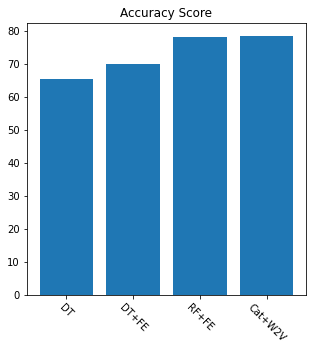

In [74]:
data = {'DT':65.3 , 'DT+FE':70, 'RF+FE':77.94, 'Cat+W2V':78.49}
plt.figure(figsize=(5,5))
plt.title('Accuracy Score')
plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()),rotation=-45)

# RandomForest + Word2Vec

In [80]:
model = RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_split=10, n_estimators=1000, random_state=12)
model = model.fit(X_train_word_average, y_train)
y_pred = model.predict(X_valid_word_average)

In [81]:
print('accuracy %s' % accuracy_score(y_valid,y_pred))
print(confusion_matrix(y_valid, y_pred, labels=['business','health','science','technology']))
print(classification_report(y_valid, y_pred))

accuracy 0.7718253968253969
[[ 91  11  13  11]
 [ 10 108  11   3]
 [  5  11 122   2]
 [ 17   8  13  68]]
              precision    recall  f1-score   support

    business       0.74      0.72      0.73       126
      health       0.78      0.82      0.80       132
     science       0.77      0.87      0.82       140
  technology       0.81      0.64      0.72       106

    accuracy                           0.77       504
   macro avg       0.77      0.76      0.77       504
weighted avg       0.77      0.77      0.77       504



## Evaluate Model RandomForest + W2V

In [114]:
acc = []
model = RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_split=10, n_estimators=1000, random_state=12)
for i, (train_index, test_index) in enumerate(kf.split(train)):

    # Create data for this fold
    y_train_cv, y_valid_cv = train['label'].iloc[train_index], train['label'].iloc[test_index]
    X_train_cv, X_valid_cv = train.iloc[train_index,:], train.iloc[test_index,:]
    print( "\nFold ", i)
    
    test_tokenized_cv = X_valid_cv.apply(lambda r: w2v_tokenize_text(r['full_text_prep']), axis=1).values
    train_tokenized_cv = X_train_cv.apply(lambda r: w2v_tokenize_text(r['full_text_prep']), axis=1).values

    X_train_word_average_cv = word_averaging_list(wv,train_tokenized_cv)
    X_test_word_average_cv = word_averaging_list(wv,test_tokenized_cv)

    # Run model for this fold

    fit_model = model.fit(X_train_word_average_cv, y_train_cv)
        
    # Generate validation predictions for this fold
    pred = fit_model.predict(X_test_word_average_cv)
    print( "  Accuracy = ", accuracy_score(y_valid_cv, pred))
    acc.append(accuracy_score(y_valid_cv, pred))
print('Mean Accuracy', np.mean(acc))


Fold  0


<ipython-input-24-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


  Accuracy =  0.7619047619047619

Fold  1


<ipython-input-24-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


  Accuracy =  0.753968253968254

Fold  2


<ipython-input-24-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


  Accuracy =  0.7658730158730159

Fold  3


<ipython-input-24-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


  Accuracy =  0.8055555555555556

Fold  4


<ipython-input-24-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


  Accuracy =  0.7380952380952381

Fold  5


<ipython-input-24-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


  Accuracy =  0.7698412698412699

Fold  6


<ipython-input-24-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


  Accuracy =  0.7649402390438247

Fold  7


<ipython-input-24-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


  Accuracy =  0.7410358565737052

Fold  8


<ipython-input-24-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


  Accuracy =  0.7529880478087649

Fold  9


<ipython-input-24-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


  Accuracy =  0.7928286852589641
Mean Accuracy 0.7647030923923355


In [115]:
np.std(acc)

0.020040519425098217

# Deep Learning BiLSTM + Glove

In [32]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.client import device_lib 
from numpy import array
from numpy import asarray
from numpy import zeros
from datetime import datetime

from gensim.models.keyedvectors import KeyedVectors

In [33]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [34]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13361966324999347881
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3131133134
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11406385167414483855
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [35]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [36]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.full_text)

lb = LabelEncoder()
X = train.full_text
y = train.label

y=lb.fit_transform(y)

X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=300)

y = to_categorical(y)

X_train_dp, X_test_dp, y_train_dp, y_test_dp = train_test_split(X, y, test_size=0.2 , random_state=15)

vocab_size = len(tokenizer.word_index) + 1

In [65]:
embeddings_dictionary = dict()

glove_file = open('glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [66]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [67]:
np.random.seed(2)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4 , min_delta=0.01)
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

with tf.device('/gpu:0'):
    model = Sequential()
    model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [68]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         2823300   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               186880    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 3,010,696
Trainable params: 3,010,696
Non-trainable params: 0
_________________________________________________________________


In [69]:
np.random.seed(2)
history = model.fit(X_train_dp,y_train_dp,validation_data=(X_test_dp,y_test_dp),epochs=10,batch_size=10 , verbose=2, callbacks=[earlystopping, tensorboard_callback])

Epoch 1/10
202/202 - 19s - loss: 0.9475 - accuracy: 0.6123 - val_loss: 0.6280 - val_accuracy: 0.7837
Epoch 2/10
202/202 - 11s - loss: 0.4393 - accuracy: 0.8539 - val_loss: 0.5765 - val_accuracy: 0.7917
Epoch 3/10
202/202 - 10s - loss: 0.2293 - accuracy: 0.9294 - val_loss: 0.6788 - val_accuracy: 0.7857
Epoch 4/10
202/202 - 11s - loss: 0.1052 - accuracy: 0.9707 - val_loss: 0.7069 - val_accuracy: 0.7917
Epoch 5/10
202/202 - 11s - loss: 0.0582 - accuracy: 0.9831 - val_loss: 0.7018 - val_accuracy: 0.7917
Epoch 6/10
202/202 - 11s - loss: 0.0282 - accuracy: 0.9950 - val_loss: 0.8448 - val_accuracy: 0.8016


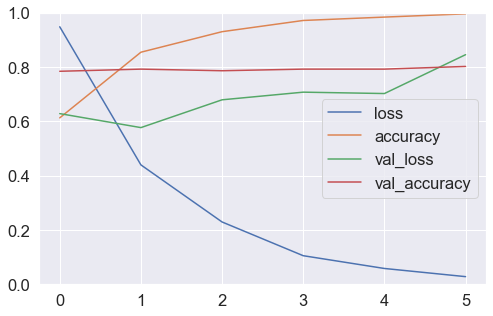

In [70]:
pd.DataFrame(history.history).plot(figsize=(8,5)) 
plt.grid(True)
plt.ylim(0,1)
plt.show()

In [71]:
y_true=np.argmax(y_test_dp, axis=1)

In [72]:
lb.classes_

array(['business', 'health', 'science', 'technology'], dtype=object)

In [73]:
y_pred = model.predict_classes(X_test_dp)
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

C:\Users\newte\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[ 88  19   7  14]
 [ 13 113   3   1]
 [  4  13 117   6]
 [ 13   4   3  86]]
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       128
           1       0.76      0.87      0.81       130
           2       0.90      0.84      0.87       140
           3       0.80      0.81      0.81       106

    accuracy                           0.80       504
   macro avg       0.80      0.80      0.80       504
weighted avg       0.80      0.80      0.80       504



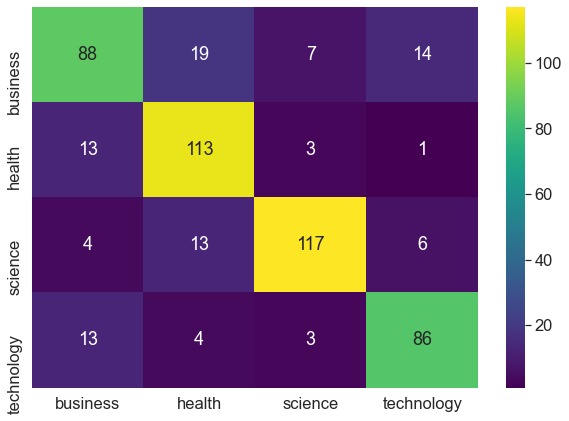

In [74]:
import seaborn as sn
cfm = [
        [88 ,19 ,7 ,14],
        [13 ,113 ,3 ,1],
        [4 ,13 ,117 ,6],
        [13, 4, 3, 86]
        ]

classes = ["business", "health", "science", "technology"]
columns_name = ["business", "health", "science", "technology"]

sns.set(font_scale=1.5)
df_cfm = pd.DataFrame(cfm, index = classes, columns = columns_name)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot=True, fmt = '', cmap="viridis")

In [98]:
X_train_1, X_valid_1 ,y_train_1, y_valid_1 = train_test_split(train, train.label, test_size=0.2, random_state=15)
X_valid_reset=X_valid_1.reset_index()

df_eva=pd.DataFrame(y_true,columns=['y_true'])
df_eva['y_pred'] = y_pred

df_eva['test'] = df_eva.apply(lambda x: x['y_true'] == x['y_pred'], axis=1)

index_false = df_eva[df_eva['test']==False].index.tolist()

X_valid_reset['y_pred'] = lb.inverse_transform(y_pred)

X_valid_reset.filter(items=index_false, axis=0)[['full_text','full_text_prep','label','y_pred']].to_excel('false_bilstm_2.xlsx')

In [95]:
lb.inverse_transform([1])

array(['health'], dtype=object)

In [96]:
X_valid_reset[X_valid_reset['full_text'] == 'LG scraps its smartphone business as losses mount The South Korean electronics giant said the mobile phone market had become "incredibly competitive".']

index                                             header        datetime  \
2   1556  LG scraps its smartphone business as losses mount  05-04-21 10:43   

                                                text     label  \
2  The South Korean electronics giant said the mo...  business   

                                           full_text  \
2  LG scraps its smartphone business as losses mo...   

                                      full_text_prep  y_pred  
2  lg scrap smartphone business loss mount south ...  health

In [78]:
df_eva[df_eva['test']==False]


y_true  y_pred   test
1         1       2  False
2         1       0  False
8         1       2  False
9         0       1  False
11        1       0  False
..      ...     ...    ...
474       0       2  False
483       0       3  False
485       1       0  False
494       1       2  False
503       0       3  False

[101 rows x 3 columns]

In [38]:
tf.keras.backend.clear_session()

## Evaluate Model

In [41]:
acc = []

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4 , min_delta=0.01)
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

for i, (train_index, test_index) in enumerate(kf.split(train)):

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train.full_text)

    lb = LabelEncoder()
    X = train.full_text
    y = train.label

    y = lb.fit_transform(y)

    X = tokenizer.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=200)

    y = to_categorical(y)

    embeddings_dictionary = dict()

    glove_file = open('glove.6B.300d.txt', encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
    glove_file.close()

    embedding_matrix = zeros((vocab_size, 300))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    
    # Create data for this fold
    y_train, y_valid = y[train_index], y[test_index]
    X_train, X_valid = X[train_index,:], X[test_index,:]
    print( "\nFold ", i)

    with tf.device('/gpu:0'):
        model = Sequential()
        model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(64)))
        model.add(Dropout(0.2))
        model.add(Dense(4,activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    # Run model for this fold
    if OPTIMIZE_ROUNDS:
        print('-------')
    else:
        History = model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=10,batch_size=10 , verbose=2, callbacks=[earlystopping, tensorboard_callback])        
    # Generate validation predictions for this fold
    score = model.evaluate(X_valid, y_valid)
    print( "  Accuracy = ", score[1])
    acc.append(score[1])

print('Mean Accuracy', np.mean(acc))


Fold  0
Epoch 1/10
227/227 - 18s - loss: 0.9287 - accuracy: 0.6427 - val_loss: 0.5984 - val_accuracy: 0.7976
Epoch 2/10
227/227 - 10s - loss: 0.4404 - accuracy: 0.8489 - val_loss: 0.5090 - val_accuracy: 0.8175
Epoch 3/10
227/227 - 10s - loss: 0.2236 - accuracy: 0.9324 - val_loss: 0.5247 - val_accuracy: 0.8214
Epoch 4/10
227/227 - 10s - loss: 0.1189 - accuracy: 0.9669 - val_loss: 0.6165 - val_accuracy: 0.7897
Epoch 5/10
227/227 - 11s - loss: 0.0494 - accuracy: 0.9876 - val_loss: 0.5281 - val_accuracy: 0.8333
Epoch 6/10
227/227 - 10s - loss: 0.0324 - accuracy: 0.9912 - val_loss: 0.6866 - val_accuracy: 0.7937
8/8 [==============================] - 0s 12ms/step - loss: 0.6866 - accuracy: 0.7937
  Accuracy =  0.7936508059501648

Fold  1
Epoch 1/10
227/227 - 19s - loss: 0.8925 - accuracy: 0.6515 - val_loss: 0.6845 - val_accuracy: 0.7341
Epoch 2/10
227/227 - 10s - loss: 0.4374 - accuracy: 0.8472 - val_loss: 0.5867 - val_accuracy: 0.7817
Epoch 3/10
227/227 - 10s - loss: 0.2400 - accuracy: 0.9

In [ ]:
X_train_1, X_valid_1 ,y_train_1, y_valid_1 = train_test_split(train, train.label, test_size=0.2, random_state=15)
X_valid_reset=X_valid_1.reset_index()

df_eva=pd.DataFrame(y_true,columns=['y_true'])
df_eva['y_pred'] = y_pred

df_eva['test'] = df_eva.apply(lambda x: x['y_true'] == x['y_pred'], axis=1)

index_false = df_eva[df_eva['test']==False].index.tolist()

X_valid_reset['y_pred'] = lb.inverse_transform(y_pred)

X_valid_reset.filter(items=index_false, axis=0)[['full_text','full_text_prep','label','y_pred']].to_excel('false_bilstm_2.xlsx')

In [46]:
np.std(acc)

0.0186496936939283

([<matplotlib.axis.XTick at 0x1b2fc036e20>,
 [Text(0, 0, 'DT'),
  Text(1, 0, 'DT+FE'),
  Text(2, 0, 'RF+FE'),
  Text(3, 0, 'Cat+W2V'),
  Text(4, 0, 'BiLSTM+GLOVE')])

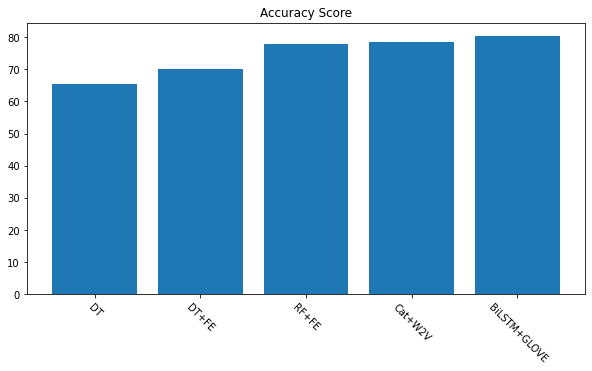

In [75]:
data = {'DT':65.4 , 'DT+FE':70, 'RF+FE':77.94, 'Cat+W2V':78.49, 'BiLSTM+GLOVE':80.44}
plt.figure(figsize=(10,5))
plt.title('Accuracy Score')
plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()),rotation=-45)

# Deep Learning BiLSTM + Google NEWs 300

In [54]:
word_vector = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
embedding_m = np.zeros((vocab_size, 300))

for word, index in tokenizer.word_index.items():
    try :
        embedding_vector = word_vector[word]
        embedding_m[index] = embedding_vector
    except KeyError:
        embedding_m[index] = np.random.normal(0,np.sqrt(0.25), 300)

In [55]:
np.random.seed(2)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4 , min_delta=0.01)
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

with tf.device('/gpu:0'):
    model = Sequential()
    model.add(Embedding(vocab_size, 300, weights=[embedding_m], trainable=True))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 300)         2823300   
_________________________________________________________________
dropout_24 (Dropout)         (None, None, 300)         0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 128)               186880    
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 516       
Total params: 3,010,696
Trainable params: 3,010,696
Non-trainable params: 0
_________________________________________________________________


In [57]:
np.random.seed(2)
history = model.fit(X_train_dp,y_train_dp,validation_data=(X_test_dp,y_test_dp),epochs=10,batch_size=10 , verbose=2, callbacks=[earlystopping, tensorboard_callback])

Epoch 1/10
202/202 - 24s - loss: 1.0343 - accuracy: 0.5845 - val_loss: 0.6547 - val_accuracy: 0.7679
Epoch 2/10
202/202 - 16s - loss: 0.4779 - accuracy: 0.8449 - val_loss: 0.6044 - val_accuracy: 0.7837
Epoch 3/10
202/202 - 16s - loss: 0.2102 - accuracy: 0.9409 - val_loss: 0.6837 - val_accuracy: 0.7560
Epoch 4/10
202/202 - 16s - loss: 0.0853 - accuracy: 0.9801 - val_loss: 0.7209 - val_accuracy: 0.7837
Epoch 5/10
202/202 - 16s - loss: 0.0327 - accuracy: 0.9945 - val_loss: 0.8521 - val_accuracy: 0.7917
Epoch 6/10
202/202 - 16s - loss: 0.0146 - accuracy: 0.9985 - val_loss: 0.9038 - val_accuracy: 0.7956


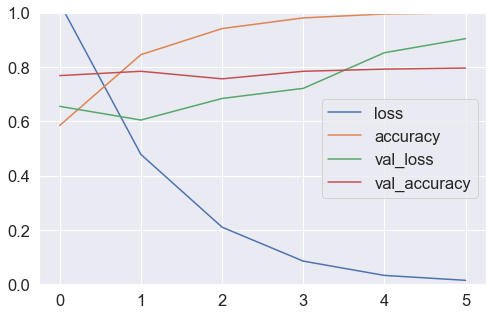

In [58]:
pd.DataFrame(history.history).plot(figsize=(8,5)) 
plt.grid(True)
plt.ylim(0,1)
plt.show()

In [59]:
y_true=np.argmax(y_test_dp, axis=1)
y_pred = model.predict_classes(X_test_dp)
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

C:\Users\newte\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[ 94  11   9  14]
 [ 16 104   4   6]
 [  8   6 119   7]
 [ 12   1   9  84]]
              precision    recall  f1-score   support

           0       0.72      0.73      0.73       128
           1       0.85      0.80      0.83       130
           2       0.84      0.85      0.85       140
           3       0.76      0.79      0.77       106

    accuracy                           0.80       504
   macro avg       0.79      0.79      0.79       504
weighted avg       0.80      0.80      0.80       504



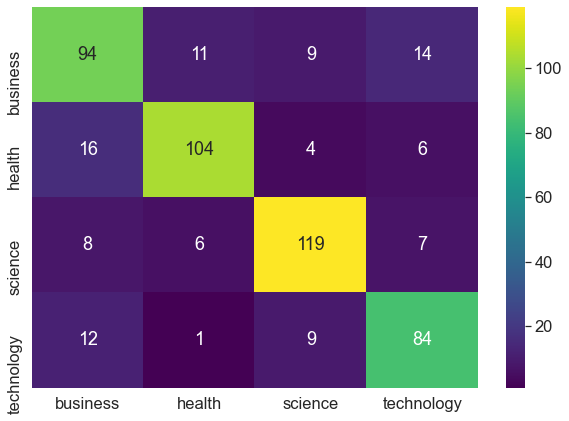

In [60]:
import seaborn as sn
cfm = confusion_matrix(y_true, y_pred)

classes = ["business", "health", "science", "technology"]
columns_name = ["business", "health", "science", "technology"]

sns.set(font_scale=1.5)
df_cfm = pd.DataFrame(cfm, index = classes, columns = columns_name)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot=True, fmt = '', cmap="viridis")

## evaluate Model

In [61]:
acc = []

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3 , min_delta=0.01)
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

for i, (train_index, test_index) in enumerate(kf.split(train)):

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train.full_text)

    lb = LabelEncoder()
    X = train.full_text
    y = train.label

    y = lb.fit_transform(y)

    X = tokenizer.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=200)

    y = to_categorical(y)

    word_vector = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
    embedding_m = np.zeros((vocab_size, 300))

    for word, index in tokenizer.word_index.items():
        try :
            embedding_vector = word_vector[word]
            embedding_m[index] = embedding_vector
        except KeyError:
            embedding_m[index] = np.random.normal(0,np.sqrt(0.25), 300)

    
    # Create data for this fold
    y_train, y_valid = y[train_index], y[test_index]
    X_train, X_valid = X[train_index,:], X[test_index,:]
    print( "\nFold ", i)

    with tf.device('/gpu:0'):
        model = Sequential()
        model.add(Embedding(vocab_size, 300, weights=[embedding_m], trainable=True))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(64)))
        model.add(Dropout(0.2))
        model.add(Dense(4,activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    # Run model for this fold
    if OPTIMIZE_ROUNDS:
        print('-------')
    else:
        History = model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=10,batch_size=10 , verbose=2, callbacks=[earlystopping, tensorboard_callback])        
    # Generate validation predictions for this fold
    score = model.evaluate(X_valid, y_valid)
    print( "  Accuracy = ", score[1])
    acc.append(score[1])

print('Mean Accuracy', np.mean(acc))


Fold  0
Epoch 1/10
227/227 - 22s - loss: 0.9677 - accuracy: 0.6091 - val_loss: 0.6646 - val_accuracy: 0.7659
Epoch 2/10
227/227 - 13s - loss: 0.4174 - accuracy: 0.8644 - val_loss: 0.5652 - val_accuracy: 0.8175
Epoch 3/10
227/227 - 13s - loss: 0.1691 - accuracy: 0.9492 - val_loss: 0.7030 - val_accuracy: 0.8095
Epoch 4/10
227/227 - 13s - loss: 0.0588 - accuracy: 0.9885 - val_loss: 0.8556 - val_accuracy: 0.7738
Epoch 5/10
227/227 - 13s - loss: 0.0386 - accuracy: 0.9890 - val_loss: 0.8228 - val_accuracy: 0.7738
8/8 [==============================] - 0s 24ms/step - loss: 0.8228 - accuracy: 0.7738
  Accuracy =  0.773809552192688

Fold  1
Epoch 1/10
227/227 - 20s - loss: 1.0063 - accuracy: 0.5733 - val_loss: 0.6879 - val_accuracy: 0.7381
Epoch 2/10
227/227 - 13s - loss: 0.4223 - accuracy: 0.8582 - val_loss: 0.6269 - val_accuracy: 0.7698
Epoch 3/10
227/227 - 13s - loss: 0.1628 - accuracy: 0.9554 - val_loss: 0.7807 - val_accuracy: 0.7381
Epoch 4/10
227/227 - 13s - loss: 0.0568 - accuracy: 0.98

([<matplotlib.axis.XTick at 0x20798406cd0>,
 [Text(0, 0, 'DT'),
  Text(1, 0, 'DT+FE'),
  Text(2, 0, 'RF+FE'),
  Text(3, 0, 'Cat+W2V'),
  Text(4, 0, 'BiLSTM+GoogleNews'),
  Text(5, 0, 'BiLSTM+GLOVE')])

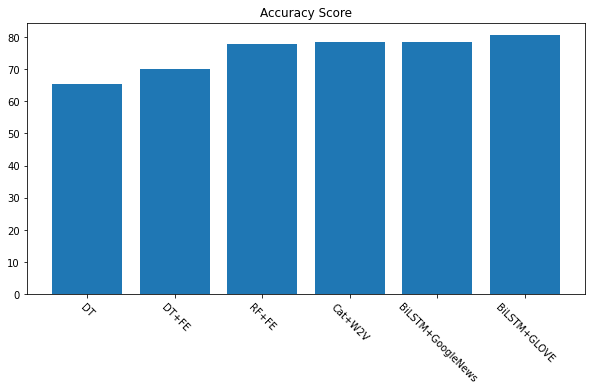

In [5]:
data = {'DT':65.4 , 'DT+FE':70, 'RF+FE':77.94, 'Cat+W2V':78.49,'BiLSTM+GoogleNews':78.33, 'BiLSTM+GLOVE':80.44}
plt.figure(figsize=(10,5))
plt.title('Accuracy Score')
plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()),rotation=-45)

In [73]:
# def build_model(dropout_rate=0, neurons=16):
#     with tf.device('/gpu:0'):
#         model = Sequential()
#         model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False))
#         model.add(Dropout(dropout_rate))
#         model.add(GRU(neurons))
#         model.add(Dropout(dropout_rate))
#         model.add(Dense(4,activation='softmax'))
#         model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
#     return model 

In [74]:
# batch_size = [16 ,32 ,64]
# epochs = [2, 5, 6, 10]
# #learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
# dropout_rate = [0.1, 0.2, 0.3]
# neurons = [16, 32, 64, 128, 256]

# param_grid = dict(batch_size=batch_size,
#                  epochs=epochs,
#                  #learning_rate=learning_rate, 
#                  dropout_rate=dropout_rate,
#                  neurons=neurons
#                  )

# model = KerasClassifier(build_fn=build_model, verbose=0)

In [76]:
# grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [134]:
def bilstm(train_index,test_index):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train.full_text)

    lb = LabelEncoder()
    X = train.full_text
    y = train.label

    y = lb.fit_transform(y)

    X = tokenizer.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=200)

    y = to_categorical(y)
    
    # Create data for this fold
    y_train, y_valid = y[train_index], y[test_index]
    X_train, X_valid = X[train_index,:], X[test_index,:]
    print( "\nFold ", i)

    with tf.device('/gpu:0'):
        model = Sequential()
        model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(128)))
        model.add(Dropout(0.2))
        model.add(Dense(4,activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    History = model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=10,batch_size=10 , verbose=2, callbacks=[earlystopping, tensorboard_callback])
    return model

In [137]:
def treeboost(train_index, test_index):
    catboost_params = {
                        'iterations': 3000,
                        'learning_rate': 0.3,
                        'eval_metric' : 'Accuracy',
                        'loss_function': 'MultiClass',
                        'task_type': 'GPU',
                        'early_stopping_rounds': 200,
                        'use_best_model': True,
                        'depth' : 6,
                        'train_dir': 'crossentropy',
                        'l2_leaf_reg' : 3
    }
    model_catw2v = CatBoostClassifier(**catboost_params)
    model_xgw2v = xgb.XGBClassifier(colsample_bylevel=0.8, colsample_bytree=0.5, gamma=0.5,
                                    learning_rate=0.2, max_depth=15, min_child_weight=10.0,
                                    n_estimators=40, objective='multi:softprob', reg_lambda=5.0,
                                    silent=False, subsample=0.9)

    # Create data for this fold
    y_train, y_valid = train['label'].iloc[train_index], train['label'].iloc[test_index]
    X_train, X_valid = train.iloc[train_index,:], train.iloc[test_index,:]
    print( "\nFold ", i)
    
    test_tokenized = X_valid.apply(lambda r: w2v_tokenize_text(r['full_text_prep']), axis=1).values
    train_tokenized = X_train.apply(lambda r: w2v_tokenize_text(r['full_text_prep']), axis=1).values

    X_train_word_average = word_averaging_list(wv,train_tokenized)
    X_test_word_average = word_averaging_list(wv,test_tokenized)

    model_cat = model_catw2v.fit(X_train_word_average, y_train, eval_set=(X_test_word_average,y_valid))
    model_xgb = model_xgw2v.fit(X_train_word_average, y_train, eval_set=[(X_test_word_average,y_valid)])
    
    return model_cat,model_xgb

In [138]:
for i, (train_index, test_index) in enumerate(kf.split(train)):
    
    model_cat, model_xg = treeboost(train_index,test_index)
    model_bilstm = bilstm(train_index,test_index)



Fold  0


<ipython-input-121-664dfaa6d69c>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


0:	learn: 0.5793407	test: 0.5217391	best: 0.5217391 (0)	total: 105ms	remaining: 5m 15s
1:	learn: 0.6285714	test: 0.5731225	best: 0.5731225 (1)	total: 137ms	remaining: 3m 25s
2:	learn: 0.6637363	test: 0.6007905	best: 0.6007905 (2)	total: 167ms	remaining: 2m 46s
3:	learn: 0.6848352	test: 0.6086957	best: 0.6086957 (3)	total: 198ms	remaining: 2m 28s
4:	learn: 0.7063736	test: 0.6205534	best: 0.6205534 (4)	total: 228ms	remaining: 2m 16s
5:	learn: 0.7301099	test: 0.6442688	best: 0.6442688 (5)	total: 260ms	remaining: 2m 9s
6:	learn: 0.7454945	test: 0.6482213	best: 0.6482213 (6)	total: 289ms	remaining: 2m 3s
7:	learn: 0.7569231	test: 0.6324111	best: 0.6482213 (6)	total: 319ms	remaining: 1m 59s
8:	learn: 0.7705495	test: 0.6363636	best: 0.6482213 (6)	total: 348ms	remaining: 1m 55s
9:	learn: 0.7841758	test: 0.6442688	best: 0.6482213 (6)	total: 380ms	remaining: 1m 53s
10:	learn: 0.7929670	test: 0.6561265	best: 0.6561265 (10)	total: 410ms	remaining: 1m 51s
11:	learn: 0.8070330	test: 0.6521739	best: 

0:	learn: 0.5687912	test: 0.5573123	best: 0.5573123 (0)	total: 42.3ms	remaining: 2m 6s
1:	learn: 0.6272527	test: 0.6007905	best: 0.6007905 (1)	total: 72ms	remaining: 1m 47s
2:	learn: 0.6668132	test: 0.5968379	best: 0.6007905 (1)	total: 102ms	remaining: 1m 41s
3:	learn: 0.6980220	test: 0.6086957	best: 0.6086957 (3)	total: 132ms	remaining: 1m 38s
4:	learn: 0.7309890	test: 0.6284585	best: 0.6284585 (4)	total: 163ms	remaining: 1m 37s
5:	learn: 0.7437363	test: 0.6205534	best: 0.6284585 (4)	total: 194ms	remaining: 1m 36s
6:	learn: 0.7617582	test: 0.6442688	best: 0.6442688 (6)	total: 224ms	remaining: 1m 35s
7:	learn: 0.7784615	test: 0.6640316	best: 0.6640316 (7)	total: 253ms	remaining: 1m 34s
8:	learn: 0.7828571	test: 0.6679842	best: 0.6679842 (8)	total: 301ms	remaining: 1m 40s
9:	learn: 0.7925275	test: 0.6798419	best: 0.6798419 (9)	total: 332ms	remaining: 1m 39s
10:	learn: 0.7986813	test: 0.6916996	best: 0.6916996 (10)	total: 361ms	remaining: 1m 38s
11:	learn: 0.8070330	test: 0.6837945	best:

0:	learn: 0.5780220	test: 0.6007905	best: 0.6007905 (0)	total: 31ms	remaining: 1m 33s
1:	learn: 0.6347253	test: 0.6205534	best: 0.6205534 (1)	total: 59.7ms	remaining: 1m 29s
2:	learn: 0.6676923	test: 0.6324111	best: 0.6324111 (2)	total: 87.4ms	remaining: 1m 27s
3:	learn: 0.6861538	test: 0.6758893	best: 0.6758893 (3)	total: 117ms	remaining: 1m 27s
4:	learn: 0.7120879	test: 0.6719368	best: 0.6758893 (3)	total: 147ms	remaining: 1m 27s
5:	learn: 0.7323077	test: 0.6798419	best: 0.6798419 (5)	total: 178ms	remaining: 1m 28s
6:	learn: 0.7454945	test: 0.6916996	best: 0.6916996 (6)	total: 207ms	remaining: 1m 28s
7:	learn: 0.7586813	test: 0.6956522	best: 0.6956522 (7)	total: 235ms	remaining: 1m 27s
8:	learn: 0.7767033	test: 0.7035573	best: 0.7035573 (8)	total: 264ms	remaining: 1m 27s
9:	learn: 0.7863736	test: 0.7154150	best: 0.7154150 (9)	total: 294ms	remaining: 1m 27s
10:	learn: 0.7964835	test: 0.7193676	best: 0.7193676 (10)	total: 324ms	remaining: 1m 27s
11:	learn: 0.8118681	test: 0.7035573	bes

0:	learn: 0.5828571	test: 0.4901186	best: 0.4901186 (0)	total: 29.8ms	remaining: 1m 29s
1:	learn: 0.6386813	test: 0.5098814	best: 0.5098814 (1)	total: 57.9ms	remaining: 1m 26s
2:	learn: 0.6716484	test: 0.5573123	best: 0.5573123 (2)	total: 85.5ms	remaining: 1m 25s
3:	learn: 0.6984615	test: 0.5375494	best: 0.5573123 (2)	total: 113ms	remaining: 1m 24s
4:	learn: 0.7239560	test: 0.5494071	best: 0.5573123 (2)	total: 142ms	remaining: 1m 25s
5:	learn: 0.7336264	test: 0.5454545	best: 0.5573123 (2)	total: 173ms	remaining: 1m 26s
6:	learn: 0.7463736	test: 0.5612648	best: 0.5612648 (6)	total: 202ms	remaining: 1m 26s
7:	learn: 0.7648352	test: 0.5494071	best: 0.5612648 (6)	total: 231ms	remaining: 1m 26s
8:	learn: 0.7780220	test: 0.5889328	best: 0.5889328 (8)	total: 260ms	remaining: 1m 26s
9:	learn: 0.7859341	test: 0.5770751	best: 0.5889328 (8)	total: 289ms	remaining: 1m 26s
10:	learn: 0.7951648	test: 0.5849802	best: 0.5889328 (8)	total: 319ms	remaining: 1m 26s
11:	learn: 0.8008791	test: 0.5968379	be

0:	learn: 0.5665934	test: 0.5335968	best: 0.5335968 (0)	total: 31.5ms	remaining: 1m 34s
1:	learn: 0.6232967	test: 0.5454545	best: 0.5454545 (1)	total: 60.4ms	remaining: 1m 30s
2:	learn: 0.6628571	test: 0.6007905	best: 0.6007905 (2)	total: 88.2ms	remaining: 1m 28s
3:	learn: 0.6839560	test: 0.6086957	best: 0.6086957 (3)	total: 118ms	remaining: 1m 28s
4:	learn: 0.7085714	test: 0.6442688	best: 0.6442688 (4)	total: 147ms	remaining: 1m 27s
5:	learn: 0.7279121	test: 0.6798419	best: 0.6798419 (5)	total: 177ms	remaining: 1m 28s
6:	learn: 0.7406593	test: 0.6719368	best: 0.6798419 (5)	total: 208ms	remaining: 1m 28s
7:	learn: 0.7600000	test: 0.7075099	best: 0.7075099 (7)	total: 238ms	remaining: 1m 29s
8:	learn: 0.7736264	test: 0.6837945	best: 0.7075099 (7)	total: 269ms	remaining: 1m 29s
9:	learn: 0.7819780	test: 0.7035573	best: 0.7075099 (7)	total: 299ms	remaining: 1m 29s
10:	learn: 0.7929670	test: 0.7114625	best: 0.7114625 (10)	total: 328ms	remaining: 1m 29s
11:	learn: 0.7995604	test: 0.7075099	b

0:	learn: 0.5846154	test: 0.5098814	best: 0.5098814 (0)	total: 29.1ms	remaining: 1m 27s
1:	learn: 0.6298901	test: 0.5770751	best: 0.5770751 (1)	total: 57.7ms	remaining: 1m 26s
2:	learn: 0.6580220	test: 0.5849802	best: 0.5849802 (2)	total: 87.3ms	remaining: 1m 27s
3:	learn: 0.6887912	test: 0.5849802	best: 0.5849802 (2)	total: 118ms	remaining: 1m 28s
4:	learn: 0.7208791	test: 0.6245059	best: 0.6245059 (4)	total: 148ms	remaining: 1m 28s
5:	learn: 0.7367033	test: 0.6324111	best: 0.6324111 (5)	total: 176ms	remaining: 1m 27s
6:	learn: 0.7485714	test: 0.6166008	best: 0.6324111 (5)	total: 206ms	remaining: 1m 27s
7:	learn: 0.7591209	test: 0.6363636	best: 0.6363636 (7)	total: 233ms	remaining: 1m 27s
8:	learn: 0.7771429	test: 0.6640316	best: 0.6640316 (8)	total: 260ms	remaining: 1m 26s
9:	learn: 0.7947253	test: 0.6719368	best: 0.6719368 (9)	total: 289ms	remaining: 1m 26s
10:	learn: 0.8057143	test: 0.6719368	best: 0.6719368 (9)	total: 320ms	remaining: 1m 27s
11:	learn: 0.8057143	test: 0.6719368	be

0:	learn: 0.5661538	test: 0.5256917	best: 0.5256917 (0)	total: 28.9ms	remaining: 1m 26s
1:	learn: 0.6035165	test: 0.5612648	best: 0.5612648 (1)	total: 54.9ms	remaining: 1m 22s
2:	learn: 0.6536264	test: 0.6086957	best: 0.6086957 (2)	total: 81.6ms	remaining: 1m 21s
3:	learn: 0.6927473	test: 0.6363636	best: 0.6363636 (3)	total: 109ms	remaining: 1m 21s
4:	learn: 0.7173626	test: 0.6363636	best: 0.6363636 (3)	total: 136ms	remaining: 1m 21s
5:	learn: 0.7446154	test: 0.6363636	best: 0.6363636 (3)	total: 166ms	remaining: 1m 22s
6:	learn: 0.7542857	test: 0.6482213	best: 0.6482213 (6)	total: 193ms	remaining: 1m 22s
7:	learn: 0.7687912	test: 0.6640316	best: 0.6640316 (7)	total: 220ms	remaining: 1m 22s
8:	learn: 0.7714286	test: 0.6561265	best: 0.6640316 (7)	total: 248ms	remaining: 1m 22s
9:	learn: 0.7863736	test: 0.6640316	best: 0.6640316 (7)	total: 277ms	remaining: 1m 22s
10:	learn: 0.7916484	test: 0.6798419	best: 0.6798419 (10)	total: 304ms	remaining: 1m 22s
11:	learn: 0.8043956	test: 0.6877470	b

0:	learn: 0.5709890	test: 0.5415020	best: 0.5415020 (0)	total: 29.6ms	remaining: 1m 28s
1:	learn: 0.6312088	test: 0.5256917	best: 0.5415020 (0)	total: 57.9ms	remaining: 1m 26s
2:	learn: 0.6738462	test: 0.5691700	best: 0.5691700 (2)	total: 85.7ms	remaining: 1m 25s
3:	learn: 0.6975824	test: 0.5889328	best: 0.5889328 (3)	total: 114ms	remaining: 1m 25s
4:	learn: 0.7120879	test: 0.6166008	best: 0.6166008 (4)	total: 143ms	remaining: 1m 25s
5:	learn: 0.7309890	test: 0.6245059	best: 0.6245059 (5)	total: 172ms	remaining: 1m 25s
6:	learn: 0.7472527	test: 0.6363636	best: 0.6363636 (6)	total: 201ms	remaining: 1m 25s
7:	learn: 0.7652747	test: 0.6521739	best: 0.6521739 (7)	total: 229ms	remaining: 1m 25s
8:	learn: 0.7789011	test: 0.6482213	best: 0.6521739 (7)	total: 258ms	remaining: 1m 25s
9:	learn: 0.7969231	test: 0.6719368	best: 0.6719368 (9)	total: 287ms	remaining: 1m 25s
10:	learn: 0.8026374	test: 0.6600791	best: 0.6719368 (9)	total: 315ms	remaining: 1m 25s
11:	learn: 0.8070330	test: 0.6561265	be

0:	learn: 0.5562390	test: 0.5079365	best: 0.5079365 (0)	total: 29.9ms	remaining: 1m 29s
1:	learn: 0.6234622	test: 0.5793651	best: 0.5793651 (1)	total: 58.4ms	remaining: 1m 27s
2:	learn: 0.6656415	test: 0.6031746	best: 0.6031746 (2)	total: 85.1ms	remaining: 1m 25s
3:	learn: 0.6876098	test: 0.6309524	best: 0.6309524 (3)	total: 114ms	remaining: 1m 25s
4:	learn: 0.7201230	test: 0.6626984	best: 0.6626984 (4)	total: 143ms	remaining: 1m 25s
5:	learn: 0.7451670	test: 0.6746032	best: 0.6746032 (5)	total: 171ms	remaining: 1m 25s
6:	learn: 0.7491213	test: 0.6785714	best: 0.6785714 (6)	total: 199ms	remaining: 1m 24s
7:	learn: 0.7719684	test: 0.6904762	best: 0.6904762 (7)	total: 225ms	remaining: 1m 24s
8:	learn: 0.7811951	test: 0.6706349	best: 0.6904762 (7)	total: 254ms	remaining: 1m 24s
9:	learn: 0.7926186	test: 0.6785714	best: 0.6904762 (7)	total: 282ms	remaining: 1m 24s
10:	learn: 0.8040422	test: 0.6428571	best: 0.6904762 (7)	total: 311ms	remaining: 1m 24s
11:	learn: 0.8159051	test: 0.6666667	be

0:	learn: 0.5746924	test: 0.5396825	best: 0.5396825 (0)	total: 29.8ms	remaining: 1m 29s
1:	learn: 0.6282953	test: 0.5634921	best: 0.5634921 (1)	total: 59ms	remaining: 1m 28s
2:	learn: 0.6739895	test: 0.6071429	best: 0.6071429 (2)	total: 87.3ms	remaining: 1m 27s
3:	learn: 0.6893673	test: 0.6230159	best: 0.6230159 (3)	total: 116ms	remaining: 1m 26s
4:	learn: 0.7148506	test: 0.6349206	best: 0.6349206 (4)	total: 144ms	remaining: 1m 26s
5:	learn: 0.7284710	test: 0.6309524	best: 0.6349206 (4)	total: 172ms	remaining: 1m 25s
6:	learn: 0.7491213	test: 0.6309524	best: 0.6349206 (4)	total: 199ms	remaining: 1m 25s
7:	learn: 0.7649385	test: 0.6666667	best: 0.6666667 (7)	total: 227ms	remaining: 1m 24s
8:	learn: 0.7811951	test: 0.6349206	best: 0.6666667 (7)	total: 255ms	remaining: 1m 24s
9:	learn: 0.7965729	test: 0.6587302	best: 0.6666667 (7)	total: 283ms	remaining: 1m 24s
10:	learn: 0.8062390	test: 0.6547619	best: 0.6666667 (7)	total: 311ms	remaining: 1m 24s
11:	learn: 0.8119508	test: 0.6666667	best

In [103]:
m = ['youTube to remove all anti vaccine misinformation','Coin hoarding at home leads to charity']
vector = TfidfVectorizer()
pd.DataFrame(vector.fit_transform(m).toarray(),columns=vector.get_feature_names())

all      anti        at   charity      coin  hoarding      home  \
0  0.392044  0.392044  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.392044  0.392044  0.392044  0.392044  0.392044   

      leads  misinformation    remove        to   vaccine   youtube  
0  0.000000        0.392044  0.392044  0.278943  0.392044  0.392044  
1  0.392044        0.000000  0.000000  0.278943  0.000000  0.000000

# TestSet

In [27]:
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'eval_metric' : 'Accuracy',
    'loss_function': 'MultiClass',
    'task_type': 'GPU',
    'early_stopping_rounds': 200,
    'use_best_model': True,
    'depth' : 6,
    'train_dir': 'crossentropy',
    'l2_leaf_reg' : 3
    }
model_cat = CatBoostClassifier(**catboost_params)
rf_final = RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_split=10, n_estimators=1000, random_state=12)

In [28]:
test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['full_text_prep']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['full_text_prep']), axis=1).values

train_word_average = word_averaging_list(wv,train_tokenized)
test_word_average = word_averaging_list(wv,test_tokenized)

<ipython-input-24-f85d644277d1>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


In [27]:
count_vec = CountVectorizer(ngram_range=(1,4))

count_vec.fit(train.full_text_prep)
train_ct = count_vec.transform(train.full_text_prep)

df_ct = pd.DataFrame(train_ct.toarray(),columns=count_vec.get_feature_names())

f_tech = df_ct[tech]
f_sc = df_ct[sc]
f_health = df_ct[health]
f_bu = df_ct[business]

list_f = [f_tech,f_sc,f_health,f_bu]
for f in list_f:
    for i in f.columns:
        f[i]=np.where(f[i]>0,1,f[i])

# f_tech['feature_tech']=f_tech.sum(axis=1)
# f_sc['feature_sc']=f_sc.sum(axis=1)
# f_bu['feature_bu'] = f_bu.sum(axis=1)
# f_health['feature_health']=f_health.sum(axis=1)

df_e = pd.DataFrame()
df_e['feature_tech']=f_tech.sum(axis=1)
df_e['feature_sc']=f_sc.sum(axis=1)
df_e['feature_bu'] = f_bu.sum(axis=1)
df_e['feature_health']=f_health.sum(axis=1)



df_e = normalize(df_e, norm="l1", axis=1)
df_w = pd.DataFrame(df_e,columns=['feature_tech',
                                    'feature_sc',
                                    'feature_bu',
                                    'feature_health'
                                    ])

tfidfvec = TfidfVectorizer(ngram_range=(1,4))
tf=tfidfvec.fit_transform(train.full_text_prep).toarray()
df_idf = pd.DataFrame(tf)
df_idf.columns = tfidfvec.get_feature_names()
df_idf.reset_index(inplace=True)

train_f = pd.concat([df_idf,df_w],axis=1)
train_f.drop(columns='index',inplace=True)

<ipython-input-27-251dc681d7a0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f[i]=np.where(f[i]>0,1,f[i])
<ipython-input-27-251dc681d7a0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f[i]=np.where(f[i]>0,1,f[i])
<ipython-input-27-251dc681d7a0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [28]:
test_ct = count_vec.transform(test.full_text_prep)

df_ct = pd.DataFrame(test_ct.toarray(),columns=count_vec.get_feature_names())
df_ct["broadband"] = 0
df_ct["hack"] = 0
df_ct["net zero"] = 0
df_ct["coronavirus evening update"] = 0
df_ct["return office"] = 0
df_ct["ride hailing"] = 0
df_ct["competition watchdog"] = 0
df_ct["investment bank"] = 0


f_tech = df_ct[tech]
f_sc = df_ct[sc]
f_health = df_ct[health]
f_bu = df_ct[business]

list_f = [f_tech,f_sc,f_health,f_bu]
for f in list_f:
    for i in f.columns:
        f[i]=np.where(f[i]>0,1,f[i])

# f_tech['feature_tech']=f_tech.sum(axis=1)
# f_sc['feature_sc']=f_sc.sum(axis=1)
# f_bu['feature_bu'] = f_bu.sum(axis=1)
# f_health['feature_health']=f_health.sum(axis=1)

df_e = pd.DataFrame()
df_e['feature_tech']=f_tech.sum(axis=1)
df_e['feature_sc']=f_sc.sum(axis=1)
df_e['feature_bu'] = f_bu.sum(axis=1)
df_e['feature_health']=f_health.sum(axis=1)



df_e = normalize(df_e, norm="l1", axis=1)
df_w = pd.DataFrame(df_e,columns=['feature_tech',
                                    'feature_sc',
                                    'feature_bu',
                                    'feature_health'
                                    ])


tf=tfidfvec.transform(test.full_text_prep).toarray()
df_idf = pd.DataFrame(tf)
df_idf.columns = tfidfvec.get_feature_names()
df_idf.reset_index(inplace=True)

test_f = pd.concat([df_idf,df_w],axis=1)
test_f.drop(columns='index',inplace=True)

<ipython-input-28-33cf87bfec9f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f[i]=np.where(f[i]>0,1,f[i])
<ipython-input-28-33cf87bfec9f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f[i]=np.where(f[i]>0,1,f[i])
<ipython-input-28-33cf87bfec9f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [29]:
rf_final.fit(train_f,train.label)

RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_split=10,
                       n_estimators=1000, random_state=12)

In [30]:
y_pred_rf = rf_final.predict(test_f)
print(classification_report(test.label, y_pred_rf))

              precision    recall  f1-score   support

    business       0.76      0.69      0.73       172
      health       0.77      0.81      0.79       164
     science       0.76      0.87      0.81       171
  technology       0.79      0.68      0.73       123

    accuracy                           0.77       630
   macro avg       0.77      0.76      0.77       630
weighted avg       0.77      0.77      0.77       630



In [30]:
model_cat.fit(train_word_average, train.label , eval_set=(test_word_average,test.label))

0:	learn: 0.5683625	test: 0.5285714	best: 0.5285714 (0)	total: 42.9ms	remaining: 42.9s
1:	learn: 0.6188394	test: 0.5571429	best: 0.5571429 (1)	total: 62.8ms	remaining: 31.3s
2:	learn: 0.6562003	test: 0.5873016	best: 0.5873016 (2)	total: 82.2ms	remaining: 27.3s
3:	learn: 0.6562003	test: 0.5984127	best: 0.5984127 (3)	total: 99.9ms	remaining: 24.9s
4:	learn: 0.6669316	test: 0.6047619	best: 0.6047619 (4)	total: 118ms	remaining: 23.6s
5:	learn: 0.6705087	test: 0.6126984	best: 0.6126984 (5)	total: 136ms	remaining: 22.6s
6:	learn: 0.6784579	test: 0.6142857	best: 0.6142857 (6)	total: 154ms	remaining: 21.9s
7:	learn: 0.6804452	test: 0.6206349	best: 0.6206349 (7)	total: 172ms	remaining: 21.3s
8:	learn: 0.6868045	test: 0.6396825	best: 0.6396825 (8)	total: 190ms	remaining: 20.9s
9:	learn: 0.7023052	test: 0.6492063	best: 0.6492063 (9)	total: 208ms	remaining: 20.6s
10:	learn: 0.7166137	test: 0.6603175	best: 0.6603175 (10)	total: 228ms	remaining: 20.5s
11:	learn: 0.7249603	test: 0.6730159	best: 0.673

In [31]:
y_pred_cat = model_cat.predict(test_word_average)
print(classification_report(test.label, y_pred_cat))

              precision    recall  f1-score   support

    business       0.75      0.77      0.76       172
      health       0.82      0.83      0.83       164
     science       0.83      0.88      0.85       171
  technology       0.80      0.70      0.74       123

    accuracy                           0.80       630
   macro avg       0.80      0.79      0.80       630
weighted avg       0.80      0.80      0.80       630



In [37]:
test['label_pred'] = y_pred_cat
test.to_csv('Test_cat.csv')

<ipython-input-37-d68443d7f00e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['label_pred'] = y_pred_cat


In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.full_text_prep)

lb = LabelEncoder()
X_train_d = train.full_text_prep
y_train_d = train.label

X_test_d = test.full_text_prep
y_test_d = test.label

y_train_d = lb.fit_transform(y_train_d)
y_test_d = lb.transform(y_test_d)

X_train_d = tokenizer.texts_to_sequences(X_train_d)
X_train_d = pad_sequences(X_train_d, maxlen=300)

X_test_d = tokenizer.texts_to_sequences(X_test_d)
X_test_d = pad_sequences(X_test_d, maxlen=300)

y_train_d = to_categorical(y_train_d)
y_test_d = to_categorical(y_test_d)

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
embeddings_dictionary = dict()

glove_file = open('glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

np.random.seed(2)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4 , min_delta=0.01)
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

with tf.device('/gpu:0'):
    model = Sequential()
    model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [41]:
history = model.fit(X_train_d,y_train_d,validation_data=(X_test_d,y_test_d),epochs=10,batch_size=10 , verbose=2, callbacks=[earlystopping, tensorboard_callback])

Epoch 1/10
252/252 - 22s - loss: 0.7729 - accuracy: 0.7166 - val_loss: 0.5495 - val_accuracy: 0.8016
Epoch 2/10
252/252 - 12s - loss: 0.3574 - accuracy: 0.8831 - val_loss: 0.5618 - val_accuracy: 0.8079
Epoch 3/10
252/252 - 12s - loss: 0.1939 - accuracy: 0.9368 - val_loss: 0.6338 - val_accuracy: 0.7952
Epoch 4/10
252/252 - 12s - loss: 0.0983 - accuracy: 0.9722 - val_loss: 0.6917 - val_accuracy: 0.7937
Epoch 5/10
252/252 - 12s - loss: 0.0494 - accuracy: 0.9833 - val_loss: 0.7834 - val_accuracy: 0.8016


In [42]:
y_true=np.argmax(y_test_d, axis=1)

In [43]:
y_pred_d = model.predict_classes(X_test_d)
print(confusion_matrix(y_true, y_pred_d))
print(classification_report(y_true, y_pred_d))

C:\Users\newte\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[128  12  18  14]
 [ 20 131   7   6]
 [  6   2 152  11]
 [ 18   4   7  94]]
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       172
           1       0.88      0.80      0.84       164
           2       0.83      0.89      0.86       171
           3       0.75      0.76      0.76       123

    accuracy                           0.80       630
   macro avg       0.80      0.80      0.80       630
weighted avg       0.80      0.80      0.80       630



In [28]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3 , min_delta=0.01)
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

word_vector = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
embedding_m = np.zeros((vocab_size, 300))

for word, index in tokenizer.word_index.items():
    try :
        embedding_vector = word_vector[word]
        embedding_m[index] = embedding_vector
    except KeyError:
        embedding_m[index] = np.random.normal(0,np.sqrt(0.25), 300)

with tf.device('/gpu:0'):
    model = Sequential()
    model.add(Embedding(vocab_size, 300, weights=[embedding_m], trainable=True))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [29]:
history = model.fit(X_train_d,y_train_d,validation_data=(X_test_d,y_test_d),epochs=10,batch_size=10 , verbose=2, callbacks=[earlystopping, tensorboard_callback])

Epoch 1/10
252/252 - 27s - loss: 0.7935 - accuracy: 0.7174 - val_loss: 0.5773 - val_accuracy: 0.7841
Epoch 2/10
252/252 - 19s - loss: 0.2947 - accuracy: 0.9058 - val_loss: 0.5764 - val_accuracy: 0.8048
Epoch 3/10
252/252 - 19s - loss: 0.1132 - accuracy: 0.9670 - val_loss: 0.6499 - val_accuracy: 0.7968
Epoch 4/10
252/252 - 19s - loss: 0.0529 - accuracy: 0.9881 - val_loss: 0.7870 - val_accuracy: 0.7968


In [30]:
y_true=np.argmax(y_test_d, axis=1)

y_pred_d = model.predict_classes(X_test_d)
print(confusion_matrix(y_true, y_pred_d))
print(classification_report(y_true, y_pred_d))

C:\Users\newte\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[133  14  10  15]
 [ 27 130   3   4]
 [ 11   5 145  10]
 [ 15   5   9  94]]
              precision    recall  f1-score   support

           0       0.72      0.77      0.74       172
           1       0.84      0.79      0.82       164
           2       0.87      0.85      0.86       171
           3       0.76      0.76      0.76       123

    accuracy                           0.80       630
   macro avg       0.80      0.79      0.80       630
weighted avg       0.80      0.80      0.80       630



([<matplotlib.axis.XTick at 0x1ea09698370>,
 [Text(0, 0, 'Rule-Base'),
  Text(1, 0, 'RF+FE'),
  Text(2, 0, 'Cat+W2V'),
  Text(3, 0, 'BiLSTM+GogleNews'),
  Text(4, 0, 'BiLSTM+Glove')])

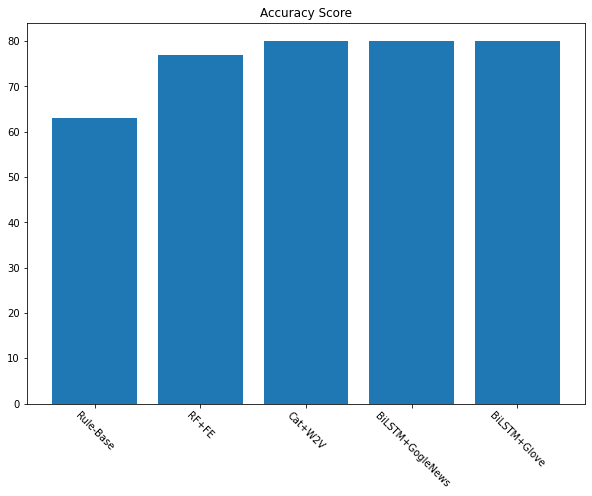

In [31]:
data = {'Rule-Base':63,'RF+FE':77, 'Cat+W2V':80,'BiLSTM+GogleNews':80,'BiLSTM+Glove':80}
plt.figure(figsize=(10,7))
plt.title('Accuracy Score')
plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()),rotation=-45)

([<matplotlib.axis.XTick at 0x1b2fd5dc160>,
 [Text(0, 0, 'RF+FE'), Text(1, 0, 'BiLSTM'), Text(2, 0, 'Cat+W2V')])

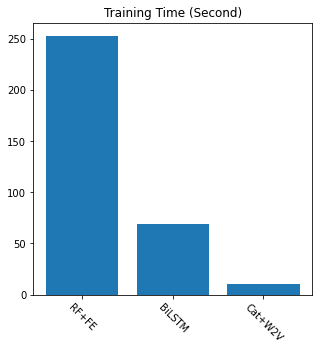

In [77]:
data = {'RF+FE':253,'BiLSTM':69, 'Cat+W2V':10}
plt.figure(figsize=(5,5))
plt.title('Training Time (Second)')
plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()),rotation=-45)

In [55]:
from gensim.models import Word2Vec
import gensim

 

wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

 

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

 

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

 

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

 

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

 

# valid_tokenized = X_valid.apply(lambda r: w2v_tokenize_text(r)).values
train_tokenized = train.full_text_prep.apply(lambda r: w2v_tokenize_text(r)).values

 

X_train_word_average = word_averaging_list(wv,train_tokenized)
# X_valid_word_average = word_averaging_list(wv,valid_tokenized)

 

# s = 'i work at facebook'

 

# e=w2v_tokenize_text(s)

 

# t=word_averaging(wv,e)
# pd.DataFrame(t)
from sklearn.manifold import TSNE
# tfidf = TfidfVectorizer()

 

# X = tfidf.fit_transform(train.full_text_prep)

 

X_embedded = TSNE(n_components=2).fit_transform(X_train_word_average)
t=pd.DataFrame()
t["x_component"]=X_embedded[:,0]
t["y_component"]=X_embedded[:,1]
t['labels']=train.label.values
import plotly.express as px
    
fig = px.scatter(t, x="x_component", y="y_component", color = "labels", size_max=60)
fig.update_layout(
     height=700,width=700)
fig.show()

<ipython-input-55-3d84fc236190>:18: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])
